In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"

In [37]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad'
adata = sc.read_h5ad(adata_with_labels_file)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [94]:
adata

AnnData object with n_obs × n_vars = 87916 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

In [95]:
#female_adata = adata[adata.obs['sex'] == 'F']
male_adata = adata[adata.obs['sex'] == 'M']

In [96]:
male_adata.obs['C_scANVI'].value_counts()

C_scANVI
Fast IIB         18566
Fast IIX         16002
EC                1911
MTJ               1767
FAPs              1609
Pericyte          1396
Macrophages       1043
Skeleton MuSc      945
Tendon             898
NMJ                651
Name: count, dtype: int64

In [ ]:
# # write male and female adata to h5ad files
# female_adata.write_h5ad(os.path.join(working_dir, 'female_scANVI_v2.h5ad'))
# male_adata.write_h5ad(os.path.join(working_dir, 'male_scANVI_v2.h5ad'))

In [54]:
male_adata.X = male_adata.layers["log1p_norm_cb"]
print(male_adata.X.max())
print(male_adata.X.min())

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_48379/1984759064.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  male_adata.X = male_adata.layers["log1p_norm_cb"]


5.7404833
0.0


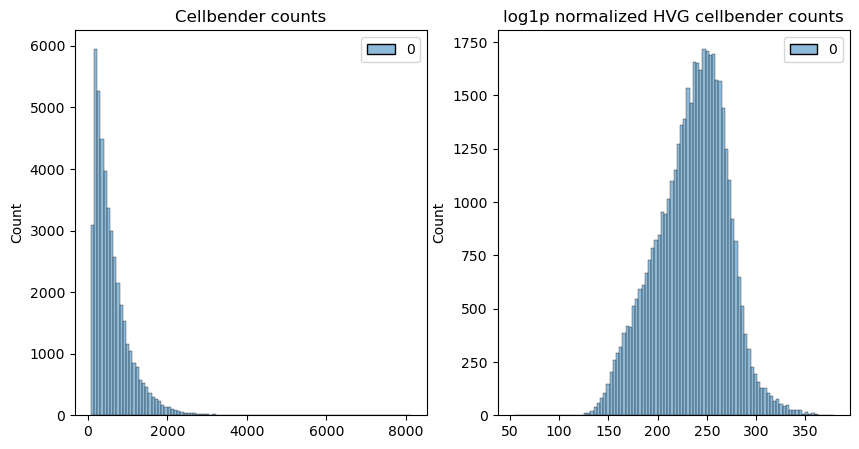

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(male_adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(male_adata.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p normalized HVG cellbender counts")
# p1 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Log1p normalized counts")
plt.show()

#### Sparsity based filtering

In [97]:
import numpy as np
from scipy.sparse import issparse

def calculate_zero_proportion(adata, axis='genes'):
    """
    Calculate the proportion of zeros for either genes (features) or cells in an AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing gene expression data
    axis : str, default 'genes'
        Which axis to calculate zeros for:
        - 'genes' or 'features' or 'columns': calculate zeros per gene (column-wise)
        - 'cells' or 'rows': calculate zeros per cell (row-wise)
        
    Returns:
    --------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each gene or cell
    """
    if axis.lower() in ['genes', 'features', 'columns']:
        # Calculate zeros per gene (column-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_cells = adata.n_obs
            non_zero_per_gene = np.array((adata.X != 0).sum(axis=0)).flatten()
            zero_per_gene = n_cells - non_zero_per_gene
            proportion_zeros = zero_per_gene / n_cells
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=0) / adata.n_obs
            
    elif axis.lower() in ['cells', 'rows']:
        # Calculate zeros per cell (row-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_genes = adata.n_vars
            non_zero_per_cell = np.array((adata.X != 0).sum(axis=1)).flatten()
            zero_per_cell = n_genes - non_zero_per_cell
            proportion_zeros = zero_per_cell / n_genes
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=1) / adata.n_vars
    else:
        raise ValueError("axis must be 'genes', 'features', 'columns', 'cells', or 'rows'")
    
    return proportion_zeros

def plot_sparsity_analysis(proportion_zeros, str='features', figsize=(14, 5), bins=50, 
                                color='steelblue', alpha=0.7, show_stats=True):
    """
    Plot cell/feature sparsity analysis with histogram and cumulative distribution.
    
    Parameters:
    -----------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each feature/cell
    figsize : tuple, default (14, 5)
        Figure size for the plots
    bins : int, default 50
        Number of bins for the histogram
    color : str, default 'steelblue'
        Color for the histogram bars
    alpha : float, default 0.7
        Transparency for the histogram bars
    show_stats : bool, default True
        Whether to print summary statistics
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : numpy.ndarray
        Array of axes objects
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Histogram of cell/feature sparsity
    axes[0].hist(proportion_zeros, bins=bins, edgecolor='black', alpha=alpha, color=color)
    axes[0].set_xlabel('Proportion of zeros')
    axes[0].set_ylabel('Number of ' + str)
    axes[0].set_title('Sparsity')
    axes[0].axvline(proportion_zeros.mean(), color='red', linestyle='--', 
                    label=f'Mean = {proportion_zeros.mean():.2f}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_props = np.sort(proportion_zeros)
    cumulative = np.arange(1, len(sorted_props) + 1) / len(sorted_props)
    axes[1].plot(sorted_props, cumulative, linewidth=2)
    axes[1].set_xlabel('Proportion of zeros')
    axes[1].set_ylabel('Cumulative fraction of ' + str)
    axes[1].set_title('Cumulative Distribution of Sparsity')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    if show_stats:
        print(f"Total {str}: {len(proportion_zeros)}")
        print(f"Mean proportion of zeros: {proportion_zeros.mean():.3f}")
        print(f"Median proportion of zeros: {np.median(proportion_zeros):.3f}")
        print(f"\n{str} by sparsity:")
        print(f"  >95% zeros: {(proportion_zeros > 0.95).sum()} {str} ({(proportion_zeros > 0.95).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >94% zeros: {(proportion_zeros > 0.94).sum()} {str} ({(proportion_zeros > 0.94).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >90% zeros: {(proportion_zeros > 0.90).sum()} {str} ({(proportion_zeros > 0.90).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  All zeros:  {(proportion_zeros == 1.0).sum()} {str}")
    
    return fig, axes


In [98]:
proportion_zeros_feature = calculate_zero_proportion(male_adata, axis='features')

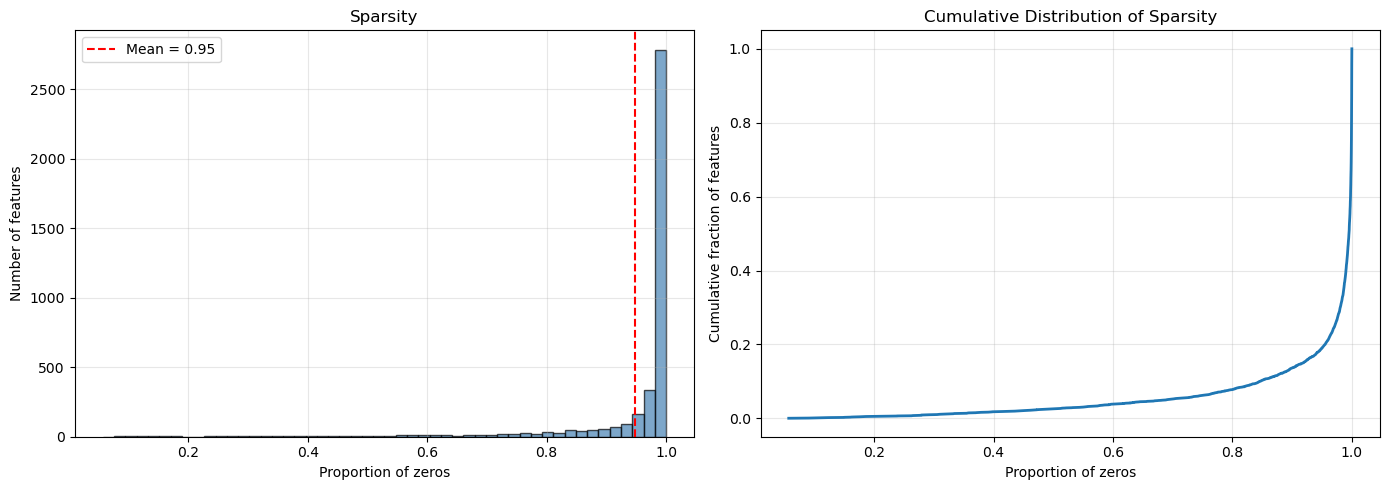

Total features: 4000
Mean proportion of zeros: 0.948
Median proportion of zeros: 0.995

features by sparsity:
  >95% zeros: 3239 features (81.0%)
  >94% zeros: 3302 features (82.5%)
  >90% zeros: 3456 features (86.4%)
  All zeros:  0 features


In [99]:
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

In [58]:
# Remove genes with all zeros
genes_to_keep = proportion_zeros_feature < 0.98

print(f"Before filtering: {male_adata.n_vars} genes")
male_adata = male_adata[:, genes_to_keep]
print(f"After filtering: {male_adata.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} genes")

Before filtering: 4000 genes
After filtering: 1188 genes
Removed: 2812 genes


In [59]:
proportion_zeros_cell = calculate_zero_proportion(male_adata, axis='cells')

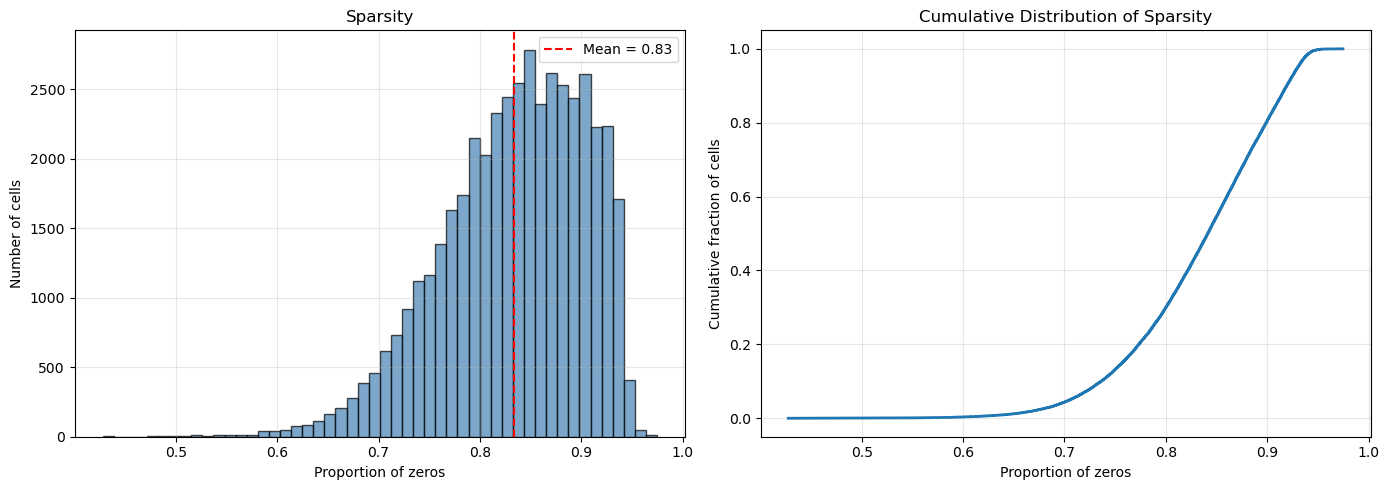

Total cells: 44788
Mean proportion of zeros: 0.833
Median proportion of zeros: 0.842

cells by sparsity:
  >95% zeros: 112 cells (0.3%)
  >94% zeros: 694 cells (1.5%)
  >90% zeros: 8687 cells (19.4%)
  All zeros:  0 cells


In [60]:
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_cell, str='cells')

In [61]:
# Remove cells
cells_to_keep = proportion_zeros_cell < 0.85

print(f"Before filtering: {male_adata.n_obs} cells")
male_adata = male_adata[cells_to_keep, :]
print(f"After filtering: {male_adata.n_obs} cells")
print(f"Removed: {(~cells_to_keep).sum()} cells")

Before filtering: 44788 cells
After filtering: 24379 cells
Removed: 20409 cells


In [62]:
# Just run this again after cell filtering
sc.pp.filter_genes(male_adata, min_cells=100)
print(f"After re-filtering genes: {male_adata.n_vars} genes")

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After re-filtering genes: 1188 genes


In [64]:
# write male and female adata to h5ad files
male_adata.write_h5ad(os.path.join(working_dir, 'male_98_85.h5ad'))

In [100]:
male_adata = sc.read_h5ad(os.path.join(working_dir, 'male_98_85.h5ad'))

In [101]:
male_adata.obs['C_scANVI'].value_counts()


C_scANVI
Fast IIB         10195
Fast IIX          9269
MTJ               1175
FAPs               750
Pericyte           662
EC                 644
NMJ                533
Tendon             533
Skeleton MuSc      357
Macrophages        261
Name: count, dtype: int64

### Filtering for slide

#### Subset to cell type of interest

In [102]:
adata_subset = male_adata[male_adata.obs['C_scANVI'] == 'Fast IIB']

In [103]:
adata_subset

View of AnnData object with n_obs × n_vars = 10195 × 1188
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

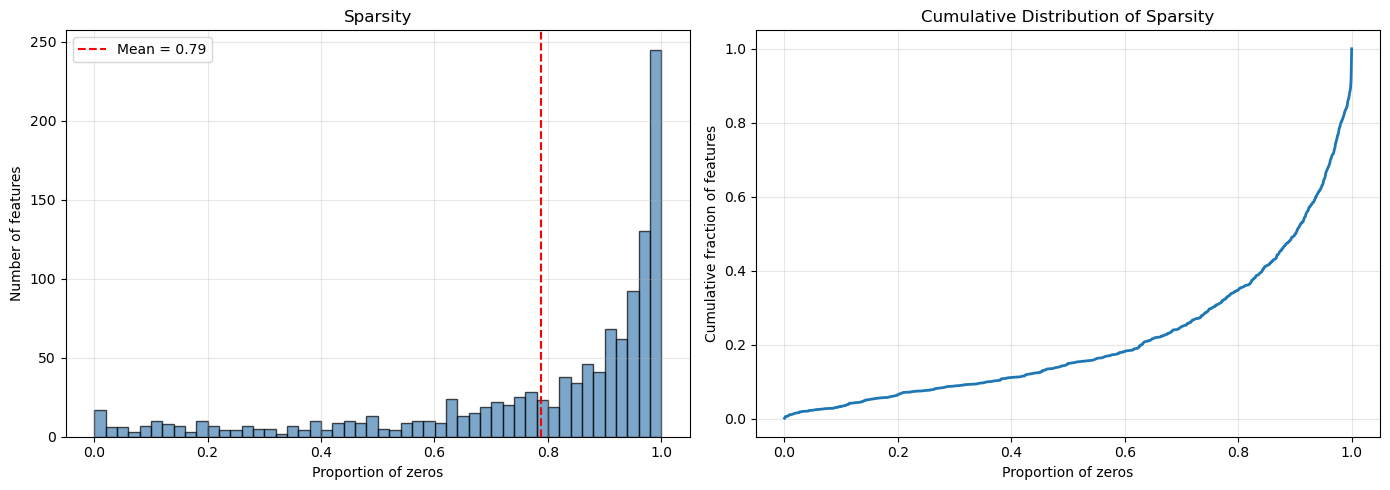

Total features: 1188
Mean proportion of zeros: 0.788
Median proportion of zeros: 0.902

features by sparsity:
  >95% zeros: 429 features (36.1%)
  >94% zeros: 467 features (39.3%)
  >90% zeros: 597 features (50.3%)
  All zeros:  7 features


In [104]:
proportion_zeros_feature = calculate_zero_proportion(adata_subset, axis='features')
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

In [105]:
genes_to_keep = proportion_zeros_feature < 0.97
print(f"Before filtering: {adata_subset.n_vars} genes")
adata_subset = adata_subset[:, genes_to_keep]
print(f"After filtering: {adata_subset.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} genes")

Before filtering: 1188 genes
After filtering: 867 genes
Removed: 321 genes


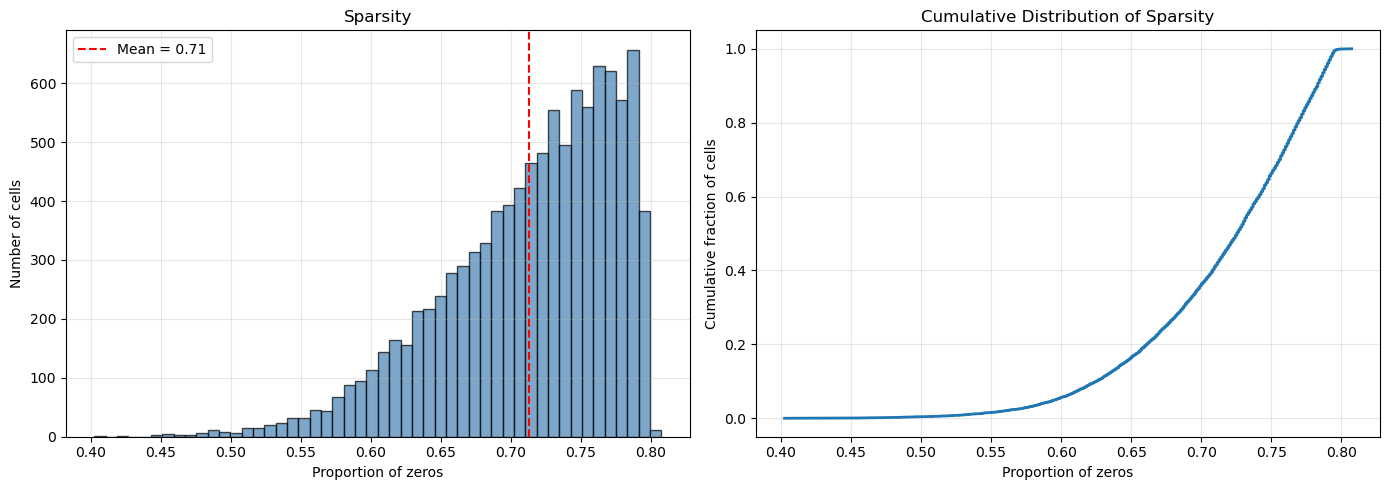

Total cells: 10195
Mean proportion of zeros: 0.713
Median proportion of zeros: 0.725

cells by sparsity:
  >95% zeros: 0 cells (0.0%)
  >94% zeros: 0 cells (0.0%)
  >90% zeros: 0 cells (0.0%)
  All zeros:  0 cells


In [106]:
proportion_zeros_cell = calculate_zero_proportion(adata_subset, axis='cells')
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_cell, str='cells')

### Variance filtering of features

In [107]:
# need to look at the variance of mean-centered data (normalized data)
adata_subset.X = adata_subset.layers["log1p_norm_cb"]

/tmp/ipykernel_48379/3503855018.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_subset.X = adata_subset.layers["log1p_norm_cb"]


/tmp/ipykernel_48379/3880909624.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_subset.var['variance'] = gene_variance


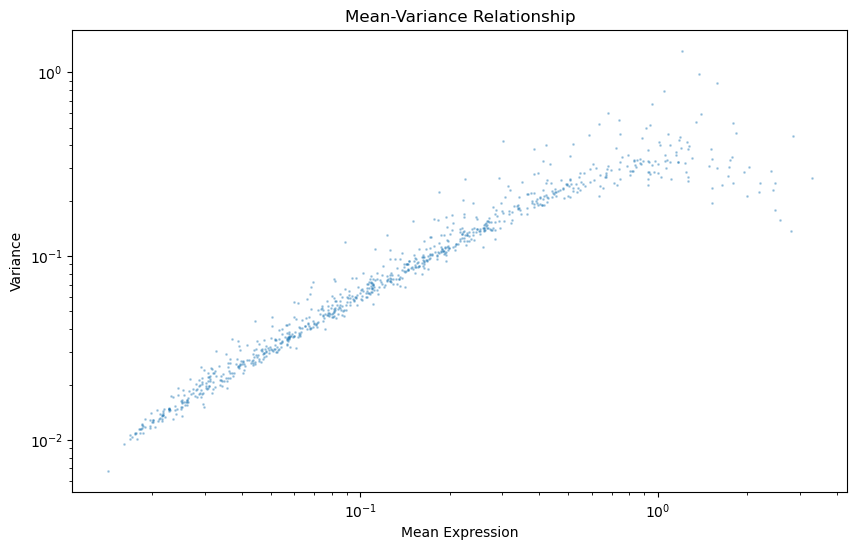

In [108]:
# Calculate mean and variance for each gene
gene_mean = np.mean(adata_subset.X.toarray() if hasattr(adata_subset.X, 'toarray') else adata_subset.X, axis=0)
gene_variance = np.var(adata_subset.X.toarray() if hasattr(adata_subset.X, 'toarray') else adata_subset.X, axis=0)

# Add variance to adata.var for easy access
adata_subset.var['variance'] = gene_variance

plt.figure(figsize=(10, 6))
plt.scatter(gene_mean, gene_variance, alpha=0.3, s=1)
plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.title('Mean-Variance Relationship')
plt.xscale('log')
plt.yscale('log')
plt.show()

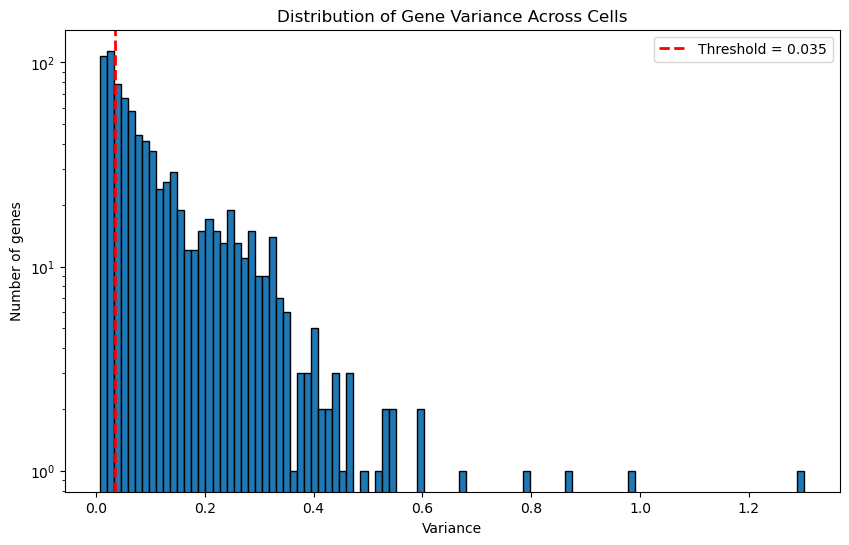

Total genes before filtering: 867
Genes above threshold (0.035): 630
Genes below threshold: 237
Percentage kept: 72.66%


In [111]:
# Set threshold (adjust based on your distribution)
variance_threshold = 0.035

# Visualize the threshold
plt.figure(figsize=(10, 6))
plt.hist(gene_variance, bins=100, edgecolor='black')
plt.axvline(variance_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {variance_threshold}')
plt.xlabel('Variance')
plt.ylabel('Number of genes')
plt.title('Distribution of Gene Variance Across Cells')
plt.yscale('log')
plt.legend()
plt.show()

# Print filtering statistics
print(f"Total genes before filtering: {adata_subset.n_vars}")
print(f"Genes above threshold ({variance_threshold}): {np.sum(gene_variance >= variance_threshold)}")
print(f"Genes below threshold: {np.sum(gene_variance < variance_threshold)}")
print(f"Percentage kept: {100 * np.sum(gene_variance >= variance_threshold) / adata_subset.n_vars:.2f}%")

In [112]:
# Filter adata to keep only high variance genes
adata_subset = adata_subset[:, adata_subset.var['variance'] >= variance_threshold].copy()
print(f"\nGenes after filtering: {adata_subset.n_vars}")


Genes after filtering: 630


In [113]:
adata_subset

AnnData object with n_obs × n_vars = 10195 × 630
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells', 'variance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_c

In [114]:
# Create Y matrix with binary encoding: KO=1, WT=0
Y = pd.DataFrame(adata_subset.obs['condition'], index=adata_subset.obs_names, columns=['condition'])

# Map condition to binary class
Y['Class'] = Y['condition'].map({'KO': 1, 'WT': 0})

# Keep only the class column
Y = Y[['Class']]

# rename the obs_names tp Barcode
Y.index.name = 'Barcode'

display(Y)

Class
Barcode                 
AAACCCAAGAACCCGA-1     1
AAACGAAAGGTAGCCA-1     1
AAACGAACAGGACGAT-1     1
AAACGAAGTCACTAGT-1     1
AAACGCTGTACGACAG-1     1
...                  ...
TGTCGAATCTTGAGTG-1     0
TGTCGTTTCTTGAGTG-1     0
TGTGCAATCATCGTCT-1     0
TGTGCAATCGCGCCTT-1     0
TGTGCCCTCGTCTCGC-1     0

[10195 rows x 1 columns]

In [115]:
# convert to df with rows as cell barcodes and columns as gene names and the X matrix as values
adata_df = pd.DataFrame(adata_subset.X.toarray(), index=adata_subset.obs_names, columns=adata_subset.var_names)
adata_df

Slco5a1     Stau2      Jph1  Gdap1     Kcnq5  Mettl21c  \
Barcode                                                                       
AAACCCAAGAACCCGA-1  0.668861  1.066098  1.750948    0.0  3.088506  0.000000   
AAACGAAAGGTAGCCA-1  1.397371  0.000000  1.397371    0.0  1.958560  0.000000   
AAACGAACAGGACGAT-1  0.000000  0.000000  2.615965    0.0  0.000000  0.000000   
AAACGAAGTCACTAGT-1  0.000000  0.000000  1.757374    0.0  1.355401  0.672658   
AAACGCTGTACGACAG-1  0.000000  0.000000  2.008787    0.0  0.000000  0.000000   
...                      ...       ...       ...    ...       ...       ...   
TGTCGAATCTTGAGTG-1  0.000000  0.845136  1.606410    0.0  0.845136  0.000000   
TGTCGTTTCTTGAGTG-1  0.635225  0.635225  1.844459    0.0  2.195781  0.000000   
TGTGCAATCATCGTCT-1  1.388126  0.000000  1.706746    0.0  0.000000  0.000000   
TGTGCAATCGCGCCTT-1  0.000000  0.000000  2.175833    0.0  0.000000  0.000000   
TGTGCCCTCGTCTCGC-1  0.000000  1.342234  0.881199    0.0  1.656585  0.000000   

                     Ankrd44  4930444A19Rik     Plcl1  Aox1  ...      Smpx  \
Barcode                                                      ...             
AAACCCAAGAACCCGA-1  1.066098            0.0  0.000000   0.0  ...  0.000000   
AAACGAAAGGTAGCCA-1  0.565961            0.0  1.188884   0.0  ...  0.000000   
AAACGAACAGGACGAT-1  0.000000            0.0  0.000000   0.0  ...  0.000000   
AAACGAAGTCACTAGT-1  0.000000            0.0  0.000000   0.0  ...  0.000000   
AAACGCTGTACGACAG-1  0.000000            0.0  0.000000   0.0  ...  1.045239   
...                      ...            ...       ...   ...  ...       ...   
TGTCGAATCTTGAGTG-1  0.000000            0.0  0.000000   0.0  ...  0.000000   
TGTCGTTTCTTGAGTG-1  0.000000            0.0  0.635225   0.0  ...  0.635225   
TGTGCAATCATCGTCT-1  0.000000            0.0  0.917757   0.0  ...  0.917757   
TGTGCAATCGCGCCTT-1  0.000000            0.0  0.000000   0.0  ...  1.925291   
TGTGCCCTCGTCTCGC-1  0.000000            0.0  0.000000   0.0  ...  0.000000   

                    Sh3kbp1      Rai2     Asb11   Arhgap6   Gm15261  Mid1  \
Barcode                                                                     
AAACCCAAGAACCCGA-1      0.0  0.668861  0.668861  0.000000  0.000000   0.0   
AAACGAAAGGTAGCCA-1      0.0  0.000000  0.000000  1.569801  0.000000   0.0   
AAACGAACAGGACGAT-1      0.0  0.000000  0.000000  0.721103  0.000000   0.0   
AAACGAAGTCACTAGT-1      0.0  0.000000  0.000000  1.355401  0.000000   0.0   
AAACGCTGTACGACAG-1      0.0  0.000000  0.653387  1.724585  1.045239   0.0   
...                     ...       ...       ...       ...       ...   ...   
TGTCGAATCTTGAGTG-1      0.0  0.000000  0.000000  1.606410  0.000000   0.0   
TGTCGTTTCTTGAGTG-1      0.0  0.000000  0.000000  1.515080  0.000000   0.0   
TGTGCAATCATCGTCT-1      0.0  0.000000  0.917757  1.388126  0.000000   0.0   
TGTGCAATCGCGCCTT-1      0.0  0.681171  0.681171  1.590207  0.000000   0.0   
TGTGCCCTCGTCTCGC-1      0.0  0.000000  0.000000  0.000000  0.000000   0.0   

                         Uty   Gm47283  Tmlhe  
Barcode                                        
AAACCCAAGAACCCGA-1  1.066098  0.000000    0.0  
AAACGAAAGGTAGCCA-1  0.925162  0.565961    0.0  
AAACGAACAGGACGAT-1  0.721103  0.000000    0.0  
AAACGAAGTCACTAGT-1  0.000000  1.071199    0.0  
AAACGCTGTACGACAG-1  0.653387  0.653387    0.0  
...                      ...       ...    ...  
TGTCGAATCTTGAGTG-1  0.000000  0.000000    0.0  
TGTCGTTTCTTGAGTG-1  0.635225  0.000000    0.0  
TGTGCAATCATCGTCT-1  0.000000  0.000000    0.0  
TGTGCAATCGCGCCTT-1  0.681171  0.681171    0.0  
TGTGCCCTCGTCTCGC-1  0.881199  0.000000    0.0  

[10195 rows x 630 columns]

In [116]:
# Sort Y by Class
Y_sorted = Y.sort_values('Class', ascending=True)

# Reorder adata_df to match the same order
adata_df_sorted = adata_df.loc[Y_sorted.index]

# Verify the order is synchronized
print("Y sorted:")
display(Y_sorted)
print(f"\nKO samples (Class=1): {(Y_sorted['Class'] == 1).sum()}")
print(f"WT samples (Class=0): {(Y_sorted['Class'] == 0).sum()}")

print("\nX matrix sorted:")
display(adata_df_sorted)

# Verify indices match
print(f"\nIndices match: {(Y_sorted.index == adata_df_sorted.index).all()}")

Y sorted:


Class
Barcode                 
AAACCCAAGAACCCGA-1     1
CCTACGAGTGCGTGGA-1     1
CCTACGAGTTATGGGA-1     1
CCTATGGGTCTCACAG-1     1
CCTATGGGTTATGTGC-1     1
...                  ...
GTTGCGGGTCACAGTT-1     0
GTTGCGGCAGCGTTTA-1     0
GTTGCGGAGGACAACC-1     0
GTTGAACCACCTCTGT-1     0
TGTGCCCTCGTCTCGC-1     0

[10195 rows x 1 columns]


KO samples (Class=1): 6197
WT samples (Class=0): 3998

X matrix sorted:


Slco5a1     Stau2      Jph1     Gdap1     Kcnq5  \
Barcode                                                                
AAACCCAAGAACCCGA-1  0.668861  1.066098  1.750948  0.000000  3.088506   
CCTACGAGTGCGTGGA-1  0.802002  1.241269  2.125848  0.000000  2.383243   
CCTACGAGTTATGGGA-1  0.661398  0.000000  1.890850  0.000000  1.338285   
CCTATGGGTCTCACAG-1  0.000000  0.000000  1.666422  0.729141  2.006843   
CCTATGGGTTATGTGC-1  0.000000  0.809803  0.809803  0.000000  0.000000   
...                      ...       ...       ...       ...       ...   
GTTGCGGGTCACAGTT-1  0.000000  1.115142  1.629241  0.705570  2.587764   
GTTGCGGCAGCGTTTA-1  1.332689  0.000000  2.237905  0.000000  0.000000   
GTTGCGGAGGACAACC-1  0.560139  0.560139  1.705747  0.000000  0.560139   
GTTGAACCACCTCTGT-1  1.008764  0.626529  2.019331  0.000000  0.835799   
TGTGCCCTCGTCTCGC-1  0.000000  1.342234  0.881199  0.000000  1.656585   

                    Mettl21c   Ankrd44  4930444A19Rik     Plcl1      Aox1  \
Barcode                                                                     
AAACCCAAGAACCCGA-1  0.000000  1.066098            0.0  0.000000  0.000000   
CCTACGAGTGCGTGGA-1  0.000000  0.000000            0.0  0.000000  0.000000   
CCTACGAGTTATGGGA-1  0.000000  0.000000            0.0  0.000000  0.000000   
CCTATGGGTCTCACAG-1  0.000000  0.000000            0.0  0.000000  0.000000   
CCTATGGGTTATGTGC-1  0.000000  0.000000            0.0  0.000000  0.000000   
...                      ...       ...            ...       ...       ...   
GTTGCGGGTCACAGTT-1  0.000000  0.000000            0.0  0.000000  0.000000   
GTTGCGGCAGCGTTTA-1  0.657732  0.000000            0.0  0.000000  0.000000   
GTTGCGGAGGACAACC-1  0.000000  0.000000            0.0  0.000000  0.917023   
GTTGAACCACCTCTGT-1  0.000000  0.361550            0.0  1.156177  0.361550   
TGTGCCCTCGTCTCGC-1  0.000000  0.000000            0.0  0.000000  0.000000   

                    ...      Smpx  Sh3kbp1      Rai2     Asb11   Arhgap6  \
Barcode             ...                                                    
AAACCCAAGAACCCGA-1  ...  0.000000      0.0  0.668861  0.668861  0.000000   
CCTACGAGTGCGTGGA-1  ...  0.000000      0.0  0.000000  0.000000  1.241269   
CCTACGAGTTATGGGA-1  ...  1.338285      0.0  0.661398  0.000000  1.056053   
CCTATGGGTCTCACAG-1  ...  0.000000      0.0  0.000000  0.000000  0.000000   
CCTATGGGTTATGTGC-1  ...  0.000000      0.0  0.000000  0.000000  0.809803   
...                 ...       ...      ...       ...       ...       ...   
GTTGCGGGTCACAGTT-1  ...  0.705570      0.0  0.000000  0.000000  0.000000   
GTTGCGGCAGCGTTTA-1  ...  0.657732      0.0  0.000000  1.051107  0.000000   
GTTGCGGAGGACAACC-1  ...  0.000000      0.0  0.000000  0.560139  1.705747   
GTTGAACCACCTCTGT-1  ...  0.626529      0.0  0.000000  0.000000  1.156177   
TGTGCCCTCGTCTCGC-1  ...  0.000000      0.0  0.000000  0.000000  0.000000   

                     Gm15261      Mid1       Uty   Gm47283     Tmlhe  
Barcode                                                               
AAACCCAAGAACCCGA-1  0.000000  0.000000  1.066098  0.000000  0.000000  
CCTACGAGTGCGTGGA-1  0.000000  0.000000  0.802002  0.000000  0.000000  
CCTACGAGTTATGGGA-1  0.000000  0.000000  0.000000  0.661398  0.661398  
CCTATGGGTCTCACAG-1  0.000000  0.729141  1.439810  0.000000  0.000000  
CCTATGGGTTATGTGC-1  0.000000  0.000000  0.809803  0.000000  0.000000  
...                      ...       ...       ...       ...       ...  
GTTGCGGGTCACAGTT-1  0.000000  0.705570  0.000000  0.705570  0.705570  
GTTGCGGCAGCGTTTA-1  0.000000  0.000000  0.000000  0.000000  0.657732  
GTTGCGGAGGACAACC-1  0.560139  0.560139  0.560139  0.560139  0.000000  
GTTGAACCACCTCTGT-1  0.835799  0.000000  0.835799  0.361550  0.835799  
TGTGCCCTCGTCTCGC-1  0.000000  0.000000  0.881199  0.000000  0.000000  

[10195 rows x 630 columns]


Indices match: True


In [117]:
# Update the original variables
Y = Y_sorted
adata_df = adata_df_sorted

In [118]:
#save to csv
out_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"
adata_df.to_csv(os.path.join(out_dir, 'male_adata_fast2b_X.csv'))

In [119]:
# save to csv
Y.to_csv(os.path.join(out_dir, 'male_adata_fast2b_Y.csv'))

## Run slide

In [1]:
import loveslide
from loveslide import OptimizeSLIDE

/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
During startup - Warning messages:
1: package ‘methods’ was built under R version 4.4.3 
2: package ‘datasets’ was built under R version 4.4.3 
3: package ‘utils’ was built under R version 4.4.3 
4: package ‘grDevices’ was built under R version 4.4.3 
5: package ‘graphics’ was built under R version 4.4.3 
6: package ‘stats’ was built under R version 4.4.3 


In [2]:
input_params = {
    'x_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_adata_fast2x_X.csv',
    'y_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_adata_fast2x_Y.csv',
    'fdr': 0.1,
    'thresh_fdr': 0.1,
    'spec': 0.2,
    'y_factor': True,
    'niter': 500,
    'SLIDE_top_feats': 20,
    'rep_CV': 50,
    'pure_homo': True,
    'delta': [0.01],
    'lambda': [0.5, 0.1],
    'out_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/male/slide_outs/fast2x'
}


### PARAMETERS ###

x_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_adata_fast2x_X.csv
y_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_adata_fast2x_Y.csv
fdr: 0.1
thresh_fdr: 0.1
spec: 0.2
y_factor: True
niter: 500
SLIDE_top_feats: 20
rep_CV: 50
pure_homo: True
delta: [0.01]
lambda: [0.5, 0.1]
out_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/male/slide_outs/fast2x
n_workers: 1
do_interacts: True

###### DATA ######

9269 samples
650 features
53.3% cases
46.7% controls

##################

Running LOVE with delta=0.01 and lambda=0.5


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package ‘tools’ was built under R version 4.4.3 



LOVE found 11 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 11
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [00:38<00:00, 38.35s/it]


Found 8 standalone LF
Finding interacting LF...


Processing subsets: 100%|██████████| 3/3 [01:07<00:00, 22.51s/it]


Found 2 interacting LF

SLIDE complete.

Completed 0.01_0.5

##################

Running LOVE with delta=0.01 and lambda=0.1
LOVE found 11 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 11
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [00:28<00:00, 28.48s/it]


Found 8 standalone LF
Finding interacting LF...


Processing subsets: 100%|██████████| 3/3 [00:51<00:00, 17.19s/it]


Found 2 interacting LF

SLIDE complete.


/ocean/projects/cis240075p/asachan/algo_dev/SLIDE_py/src/loveslide/plotting.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')



Completed 0.01_0.1

##################



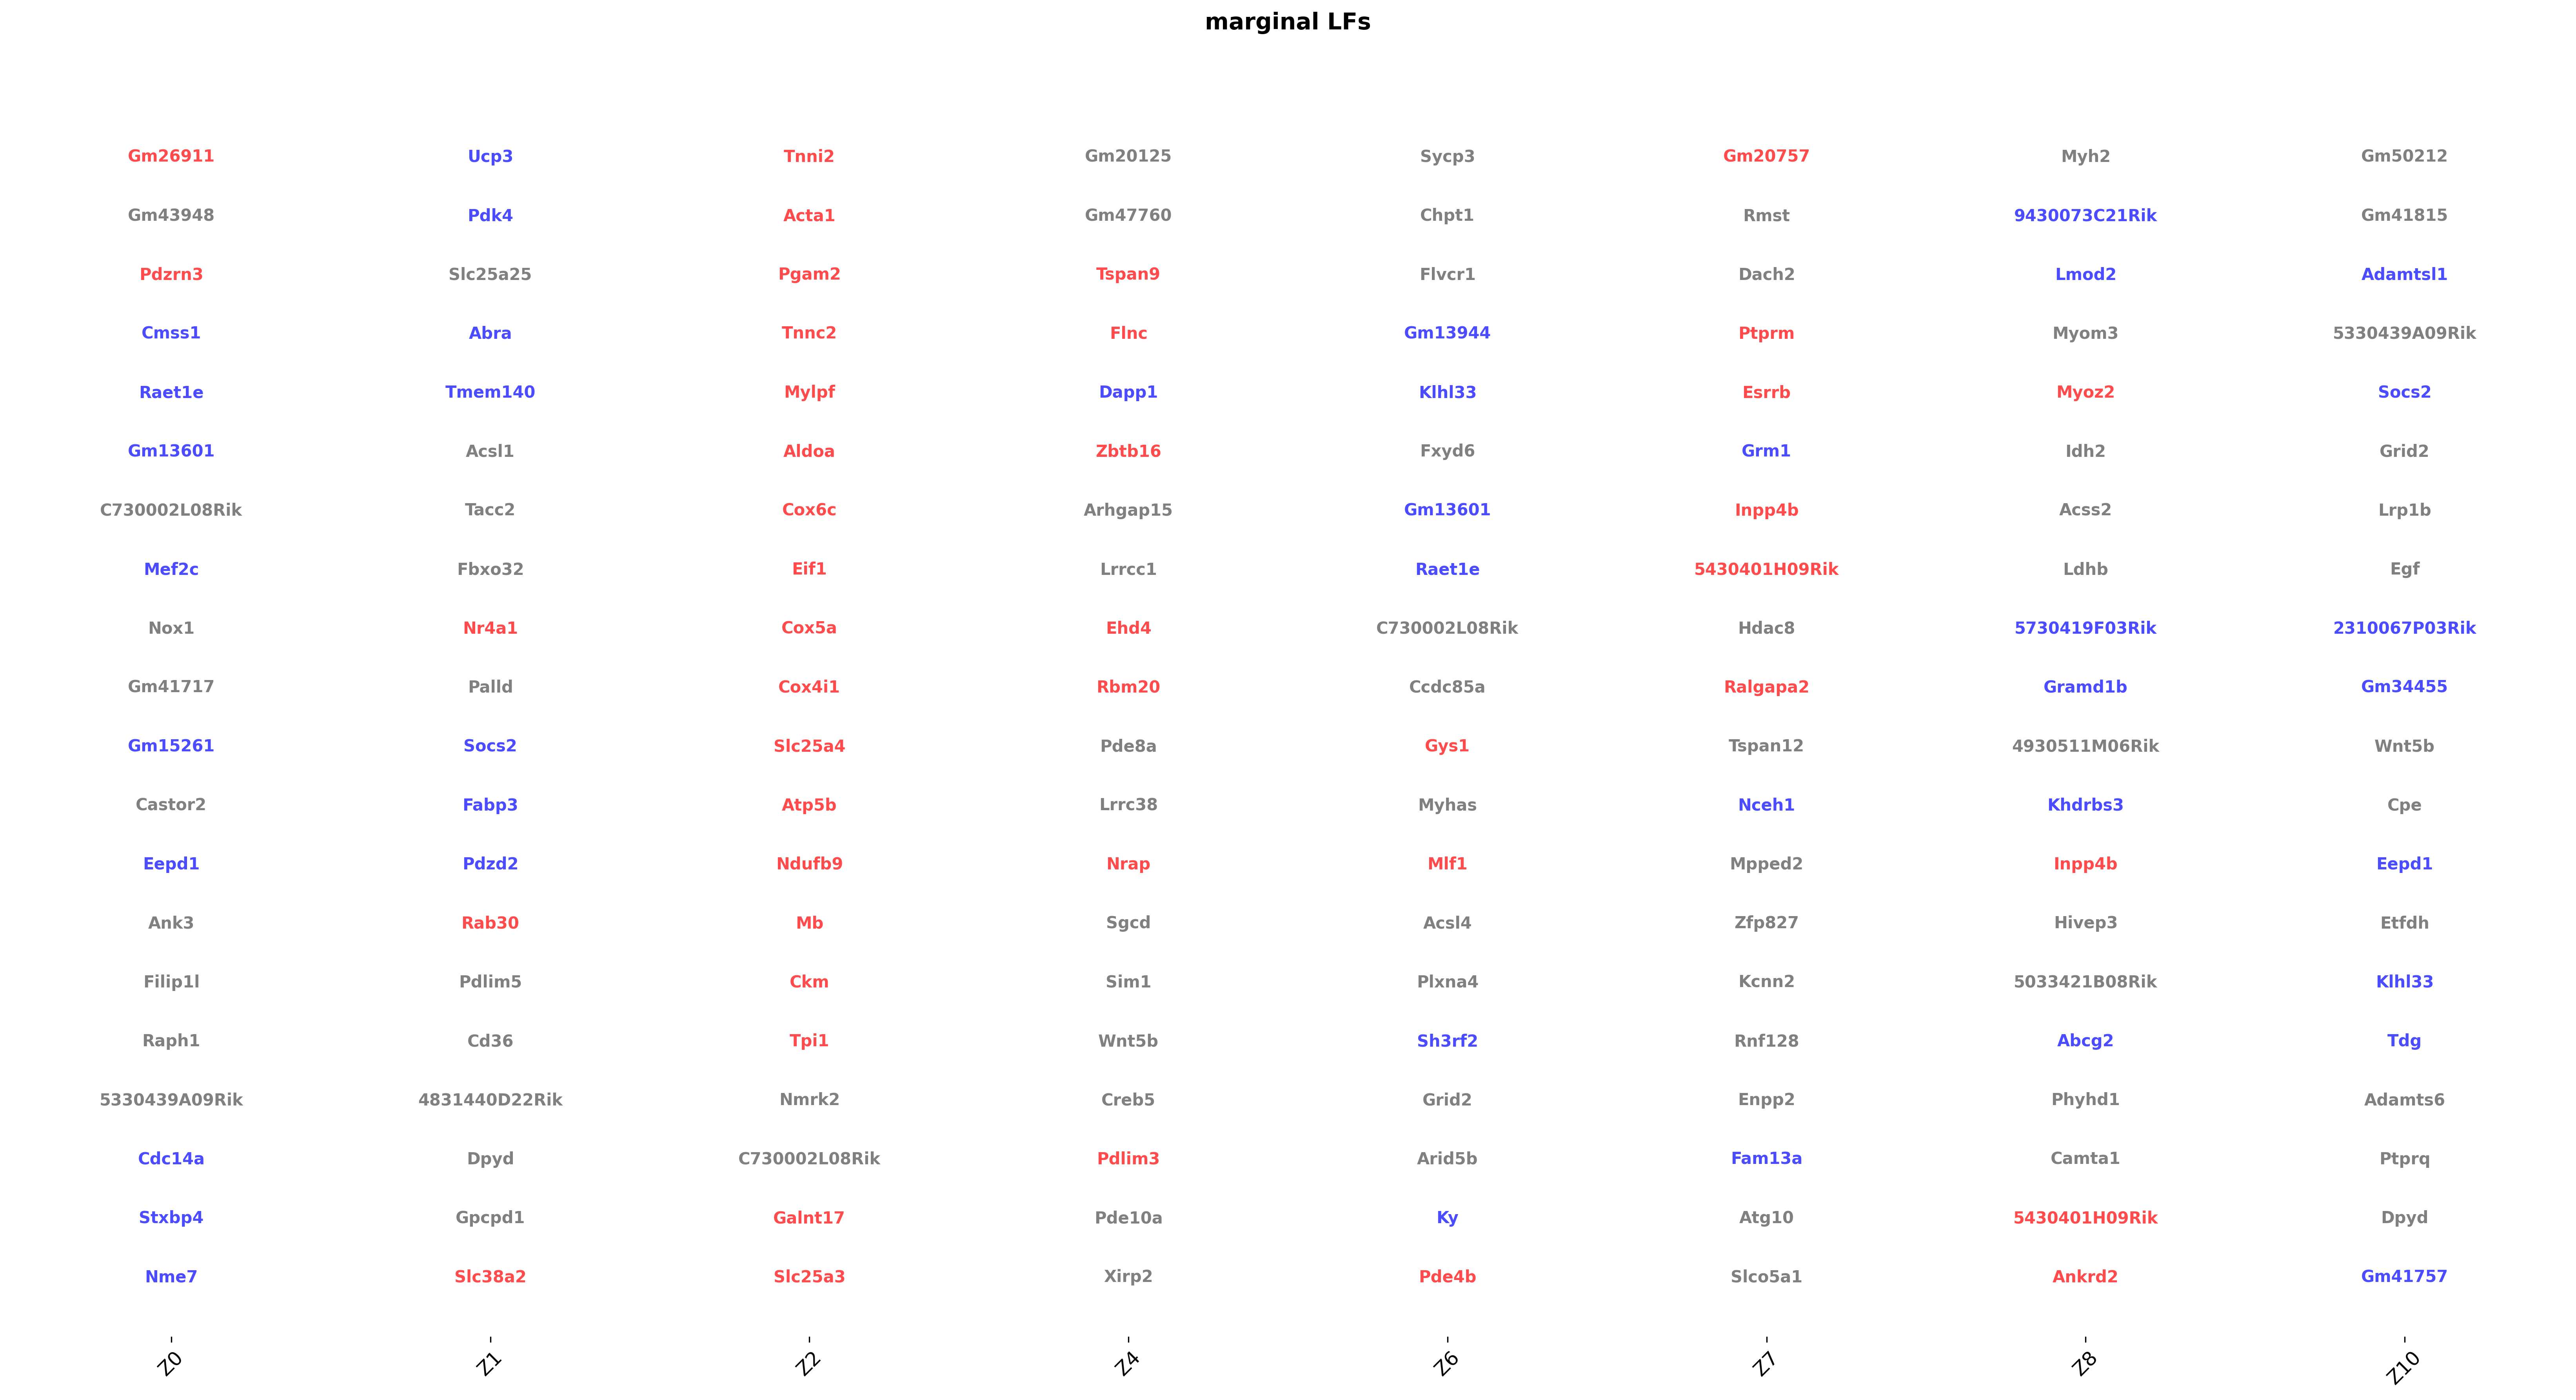

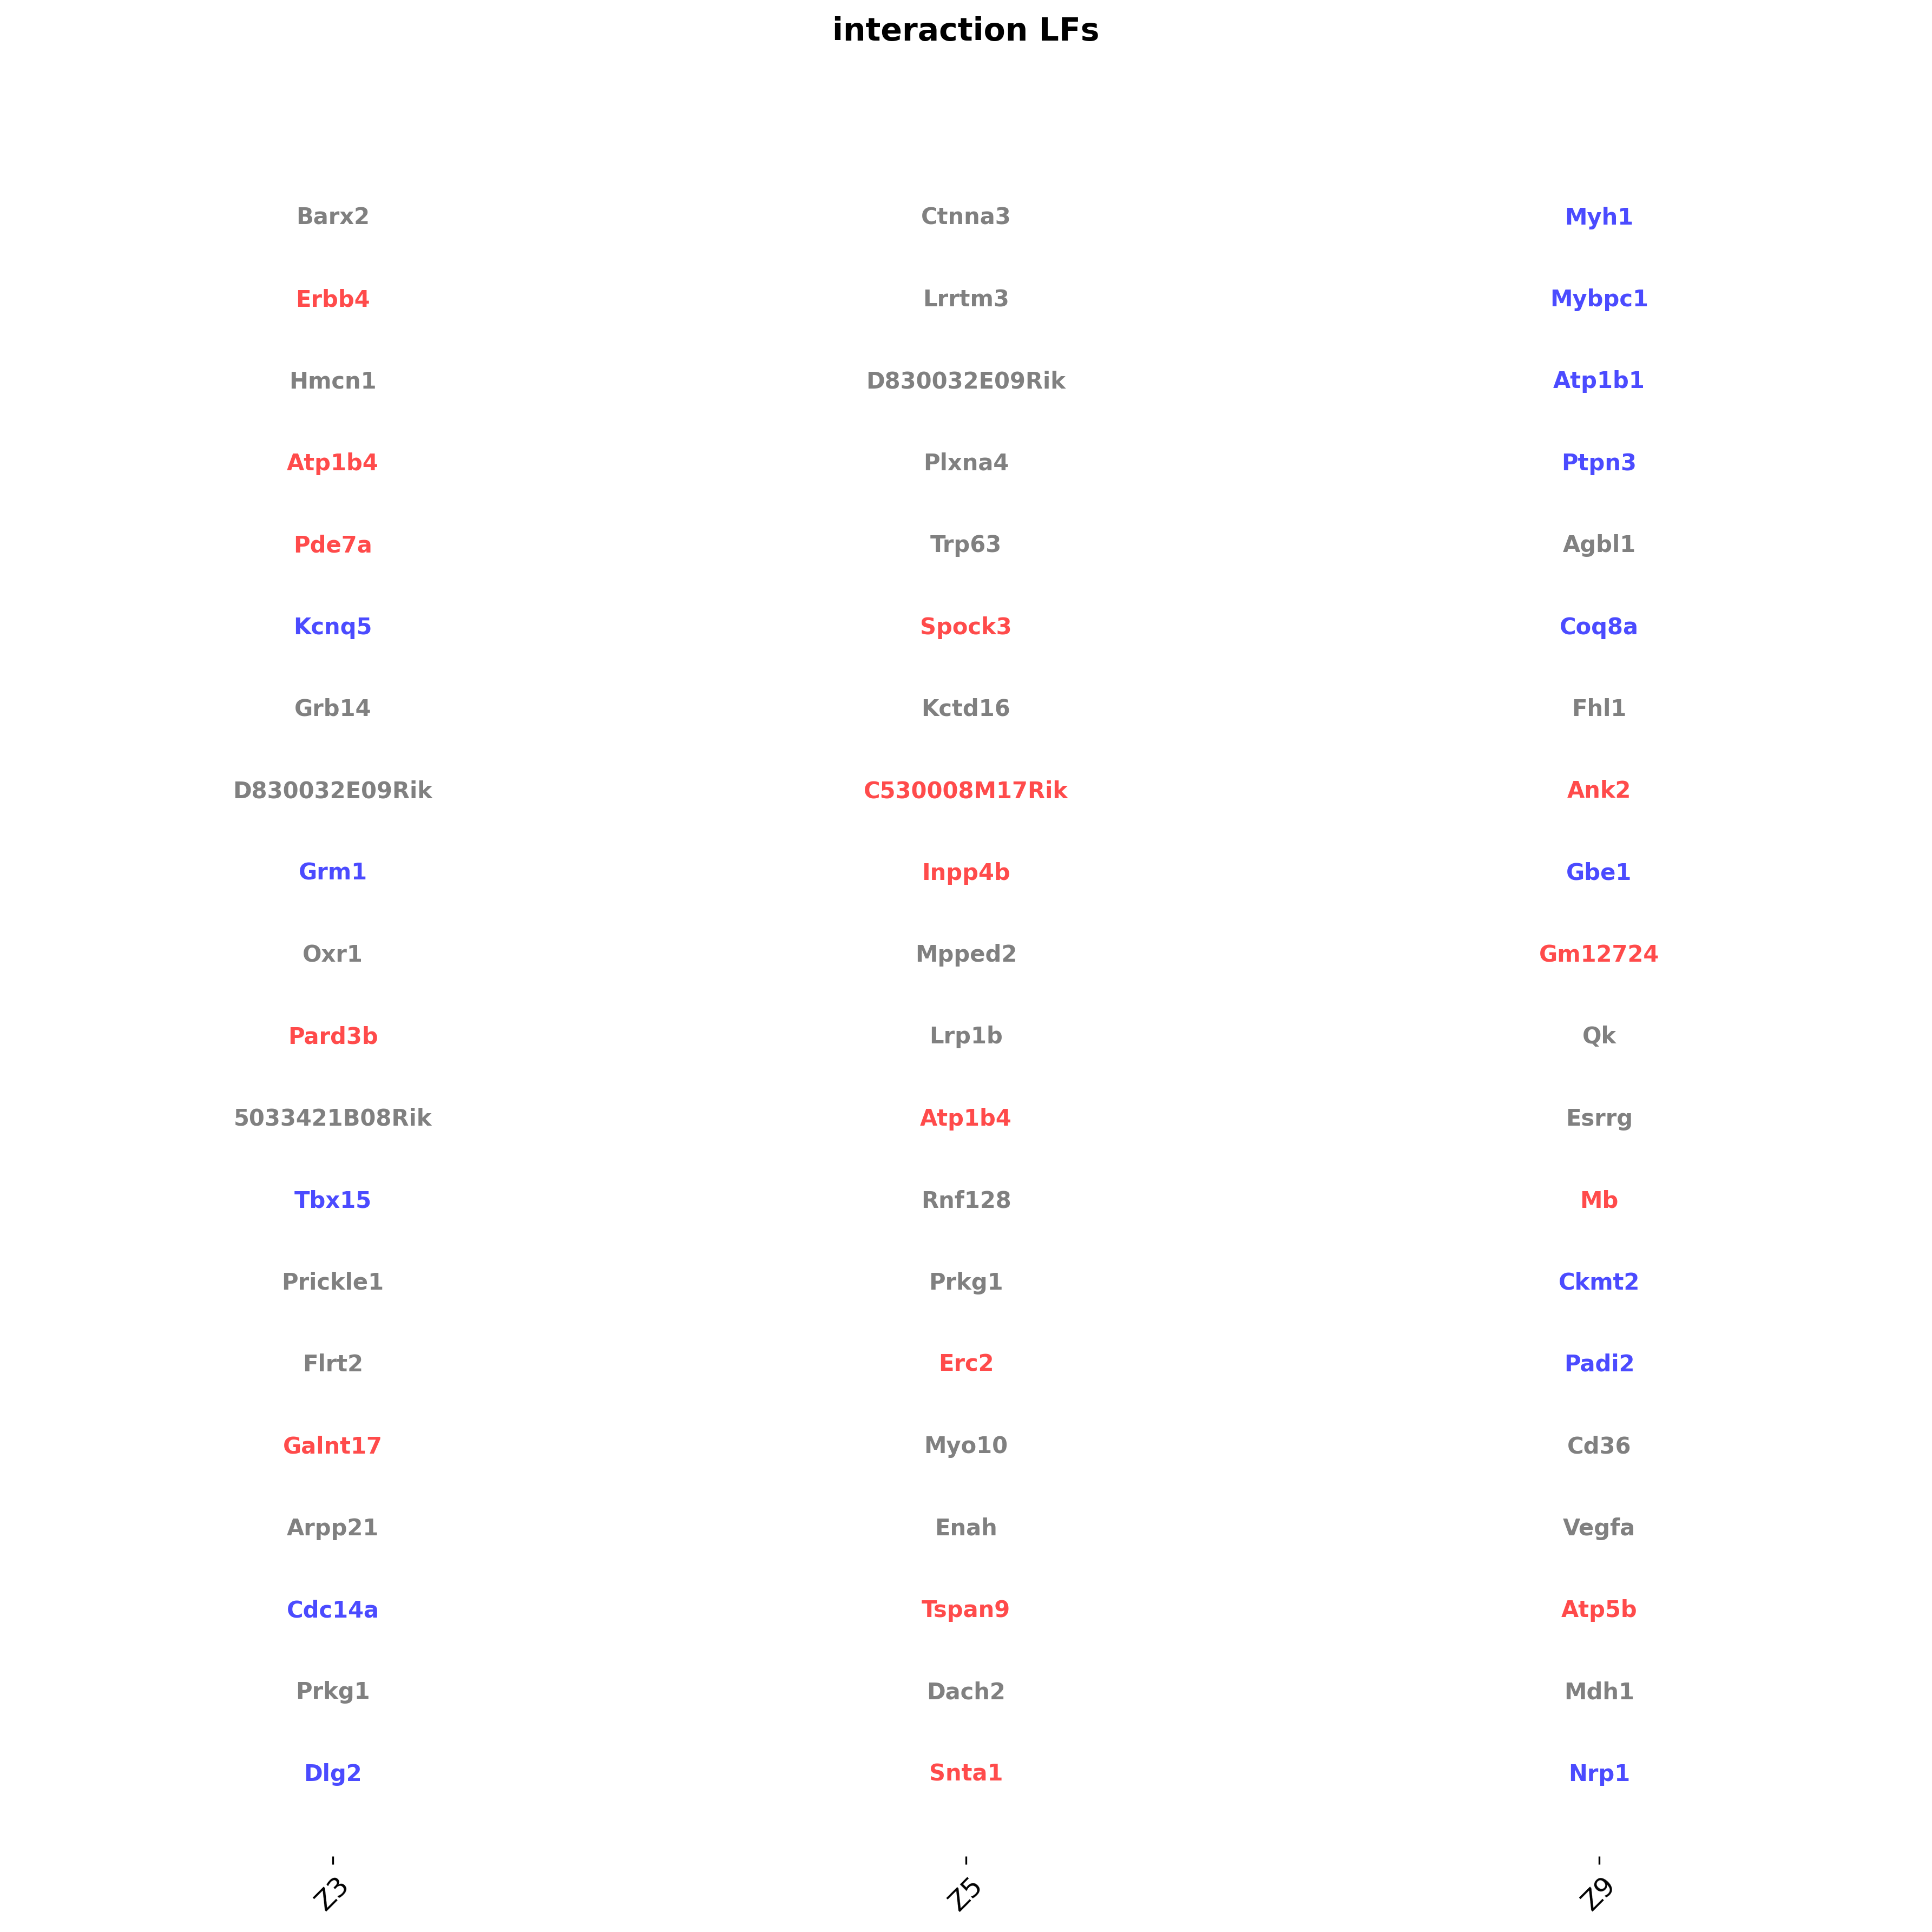

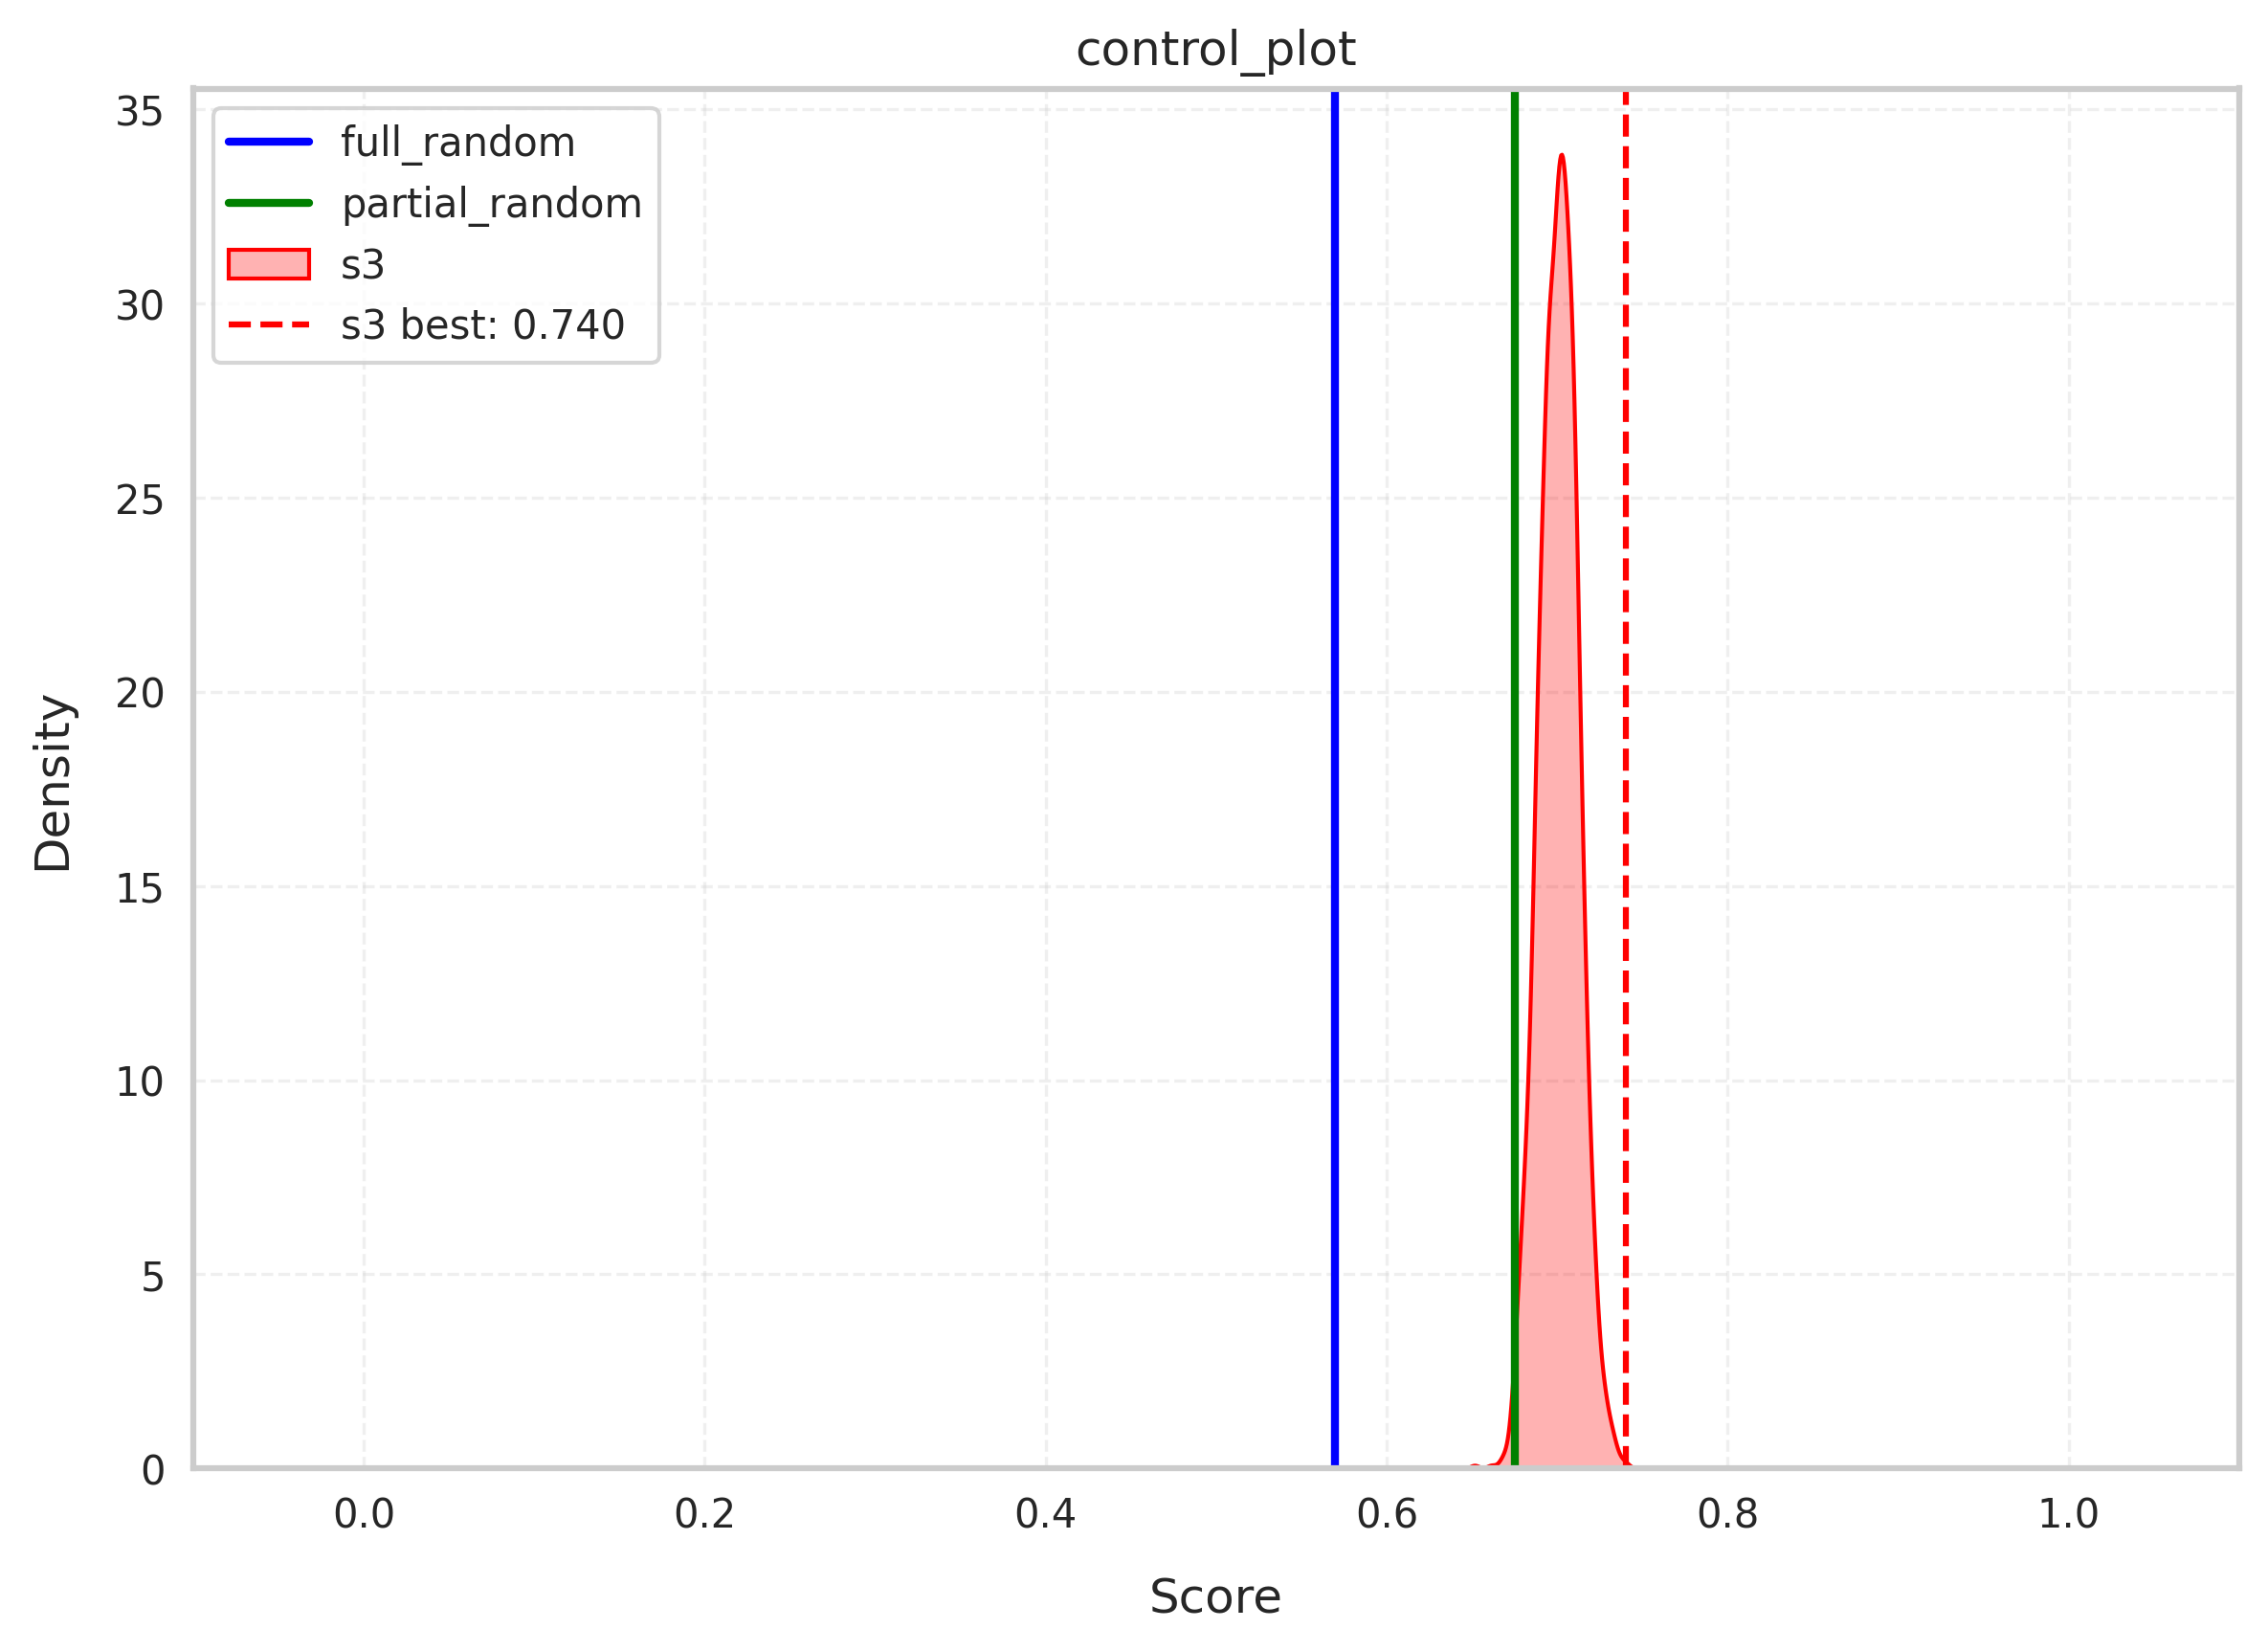

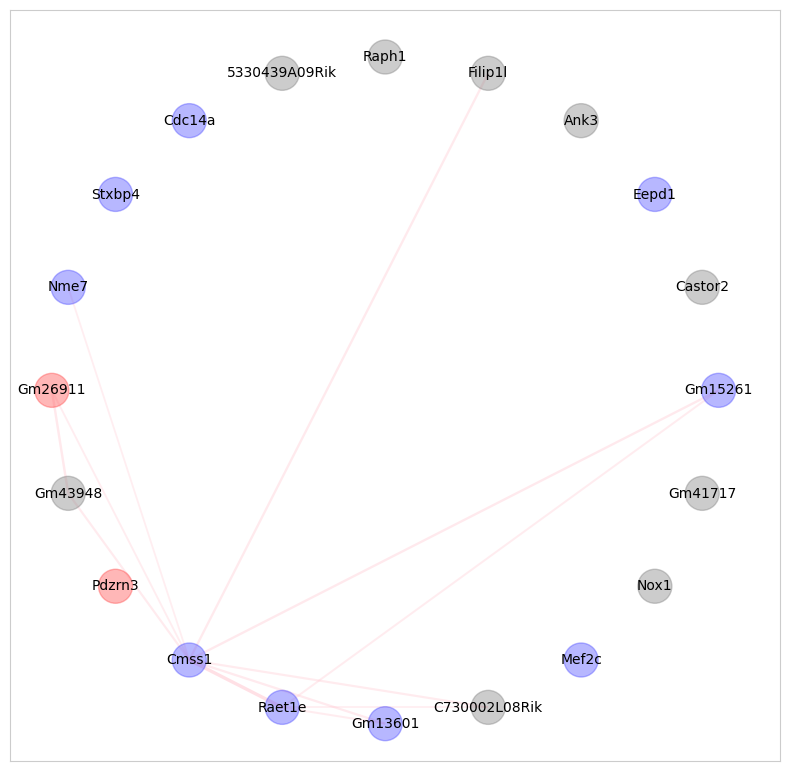

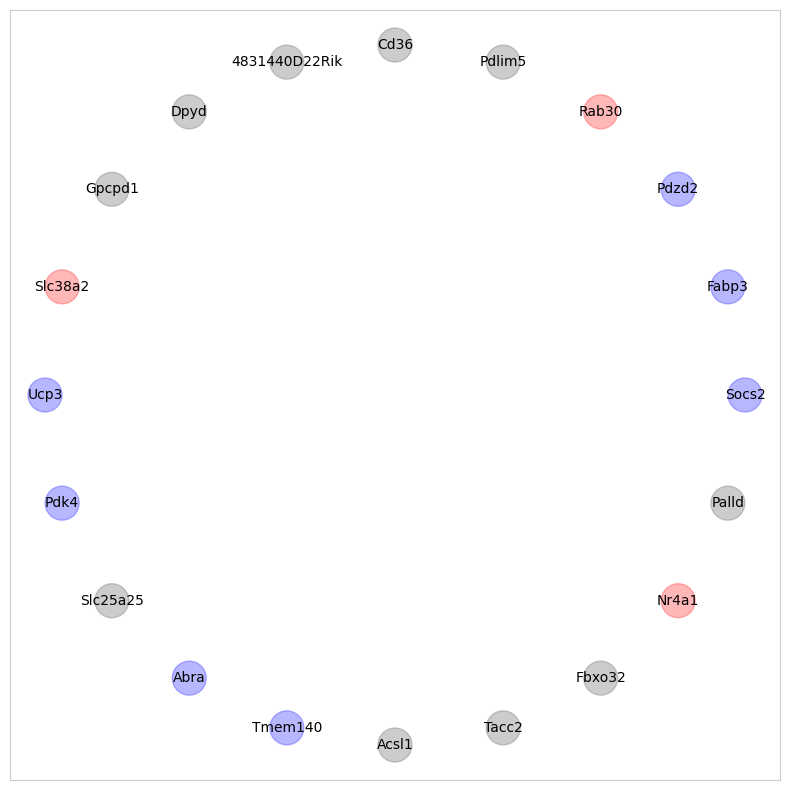

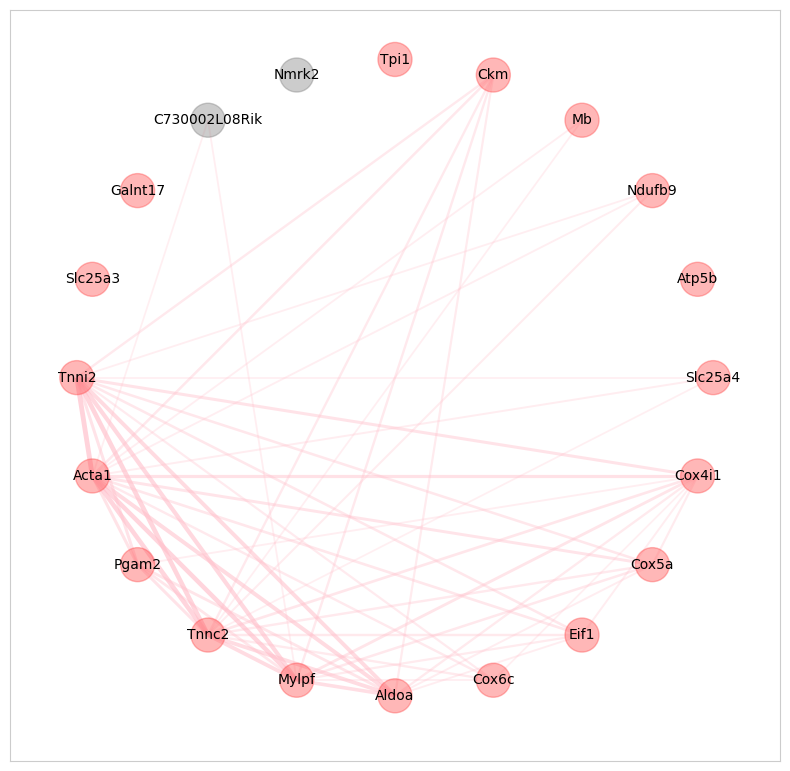

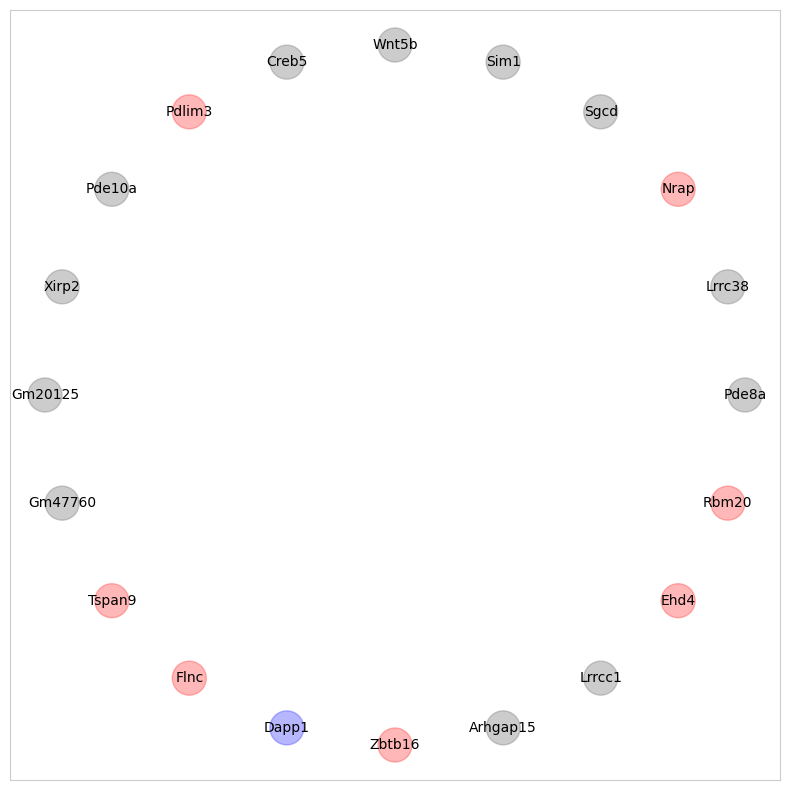

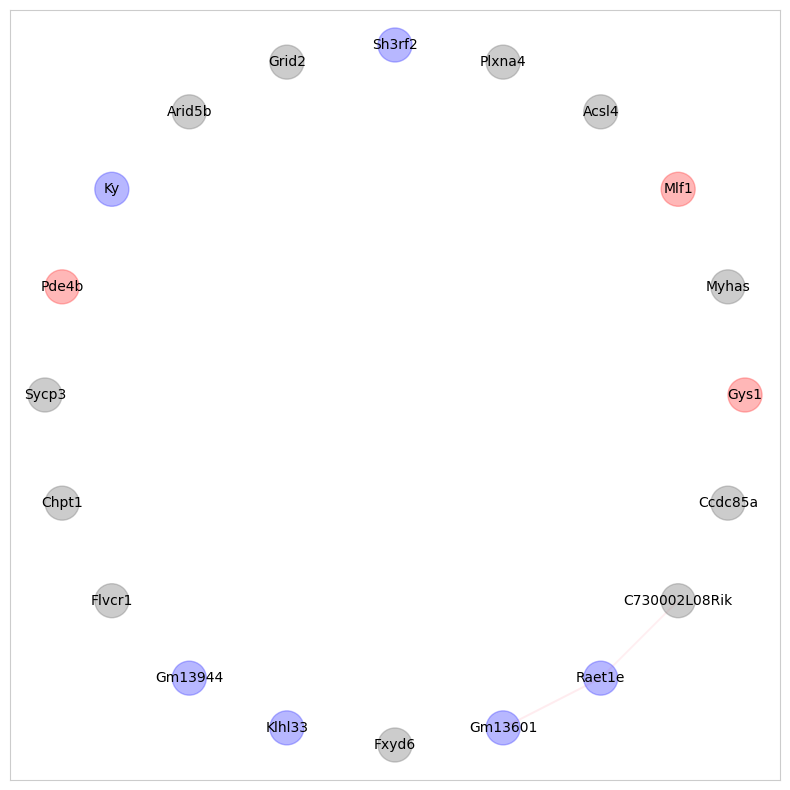

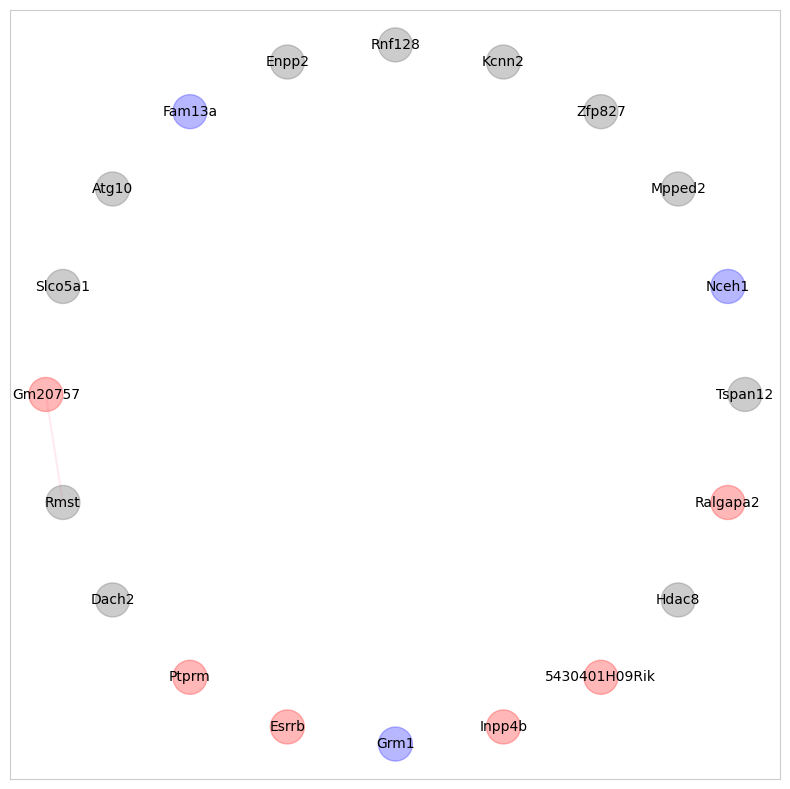

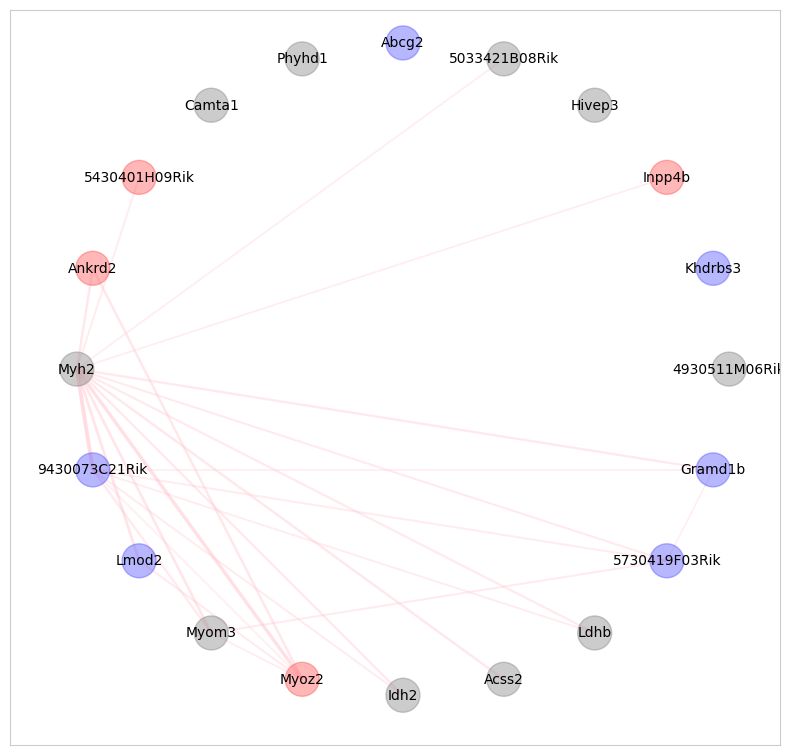

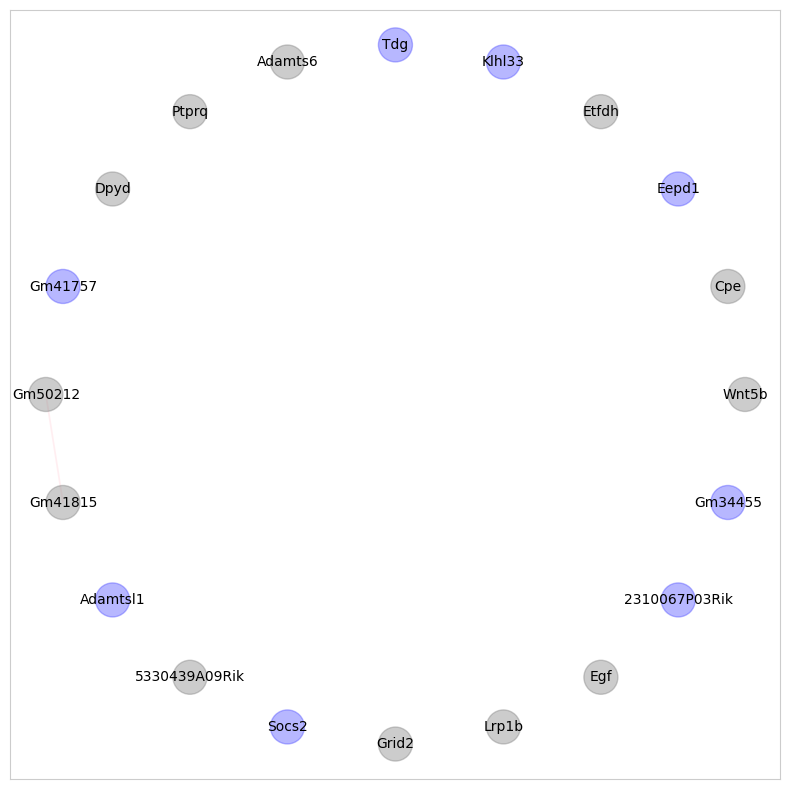

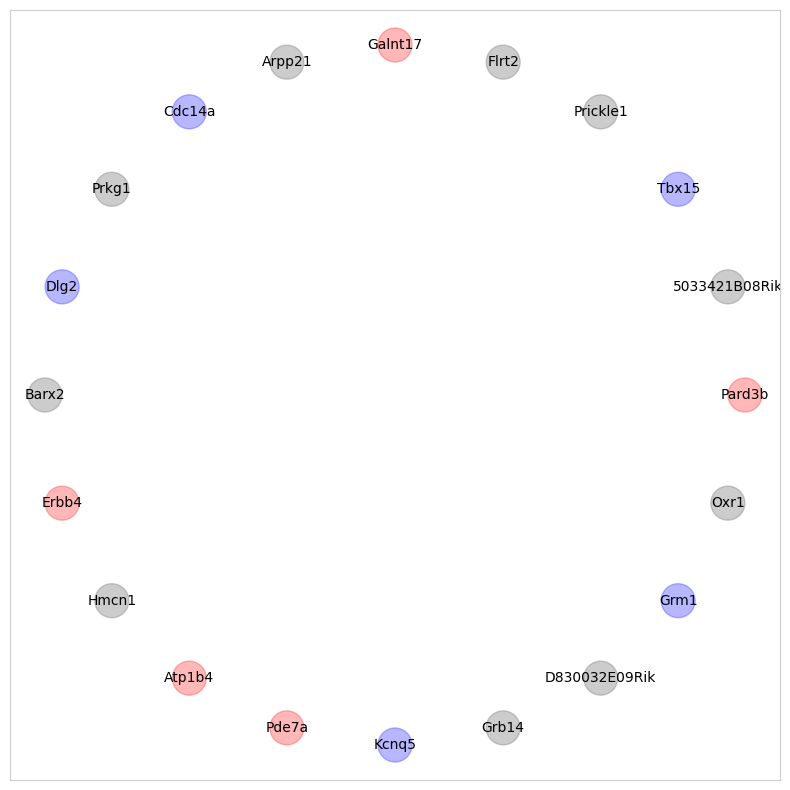

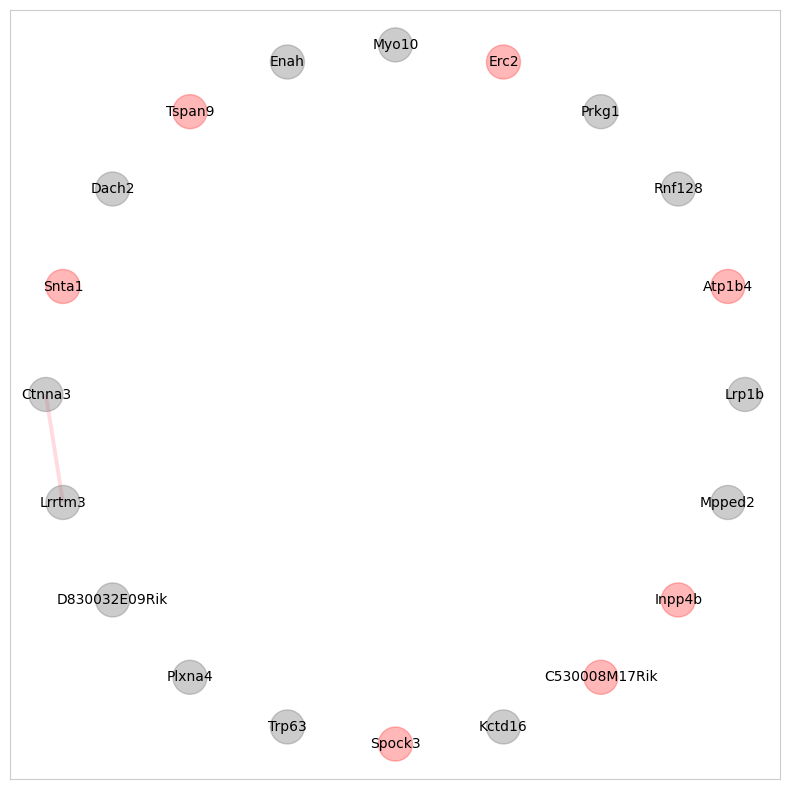

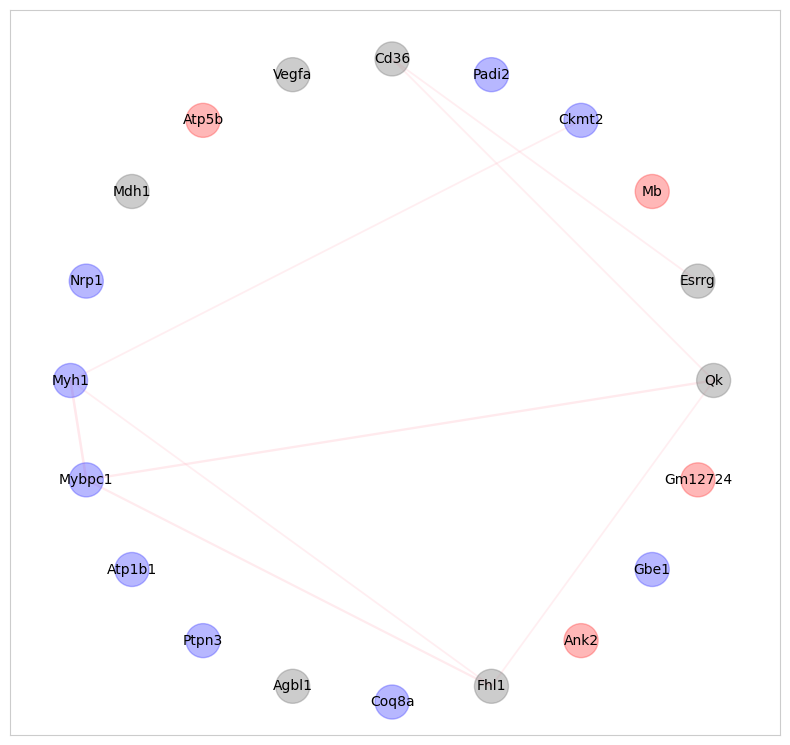

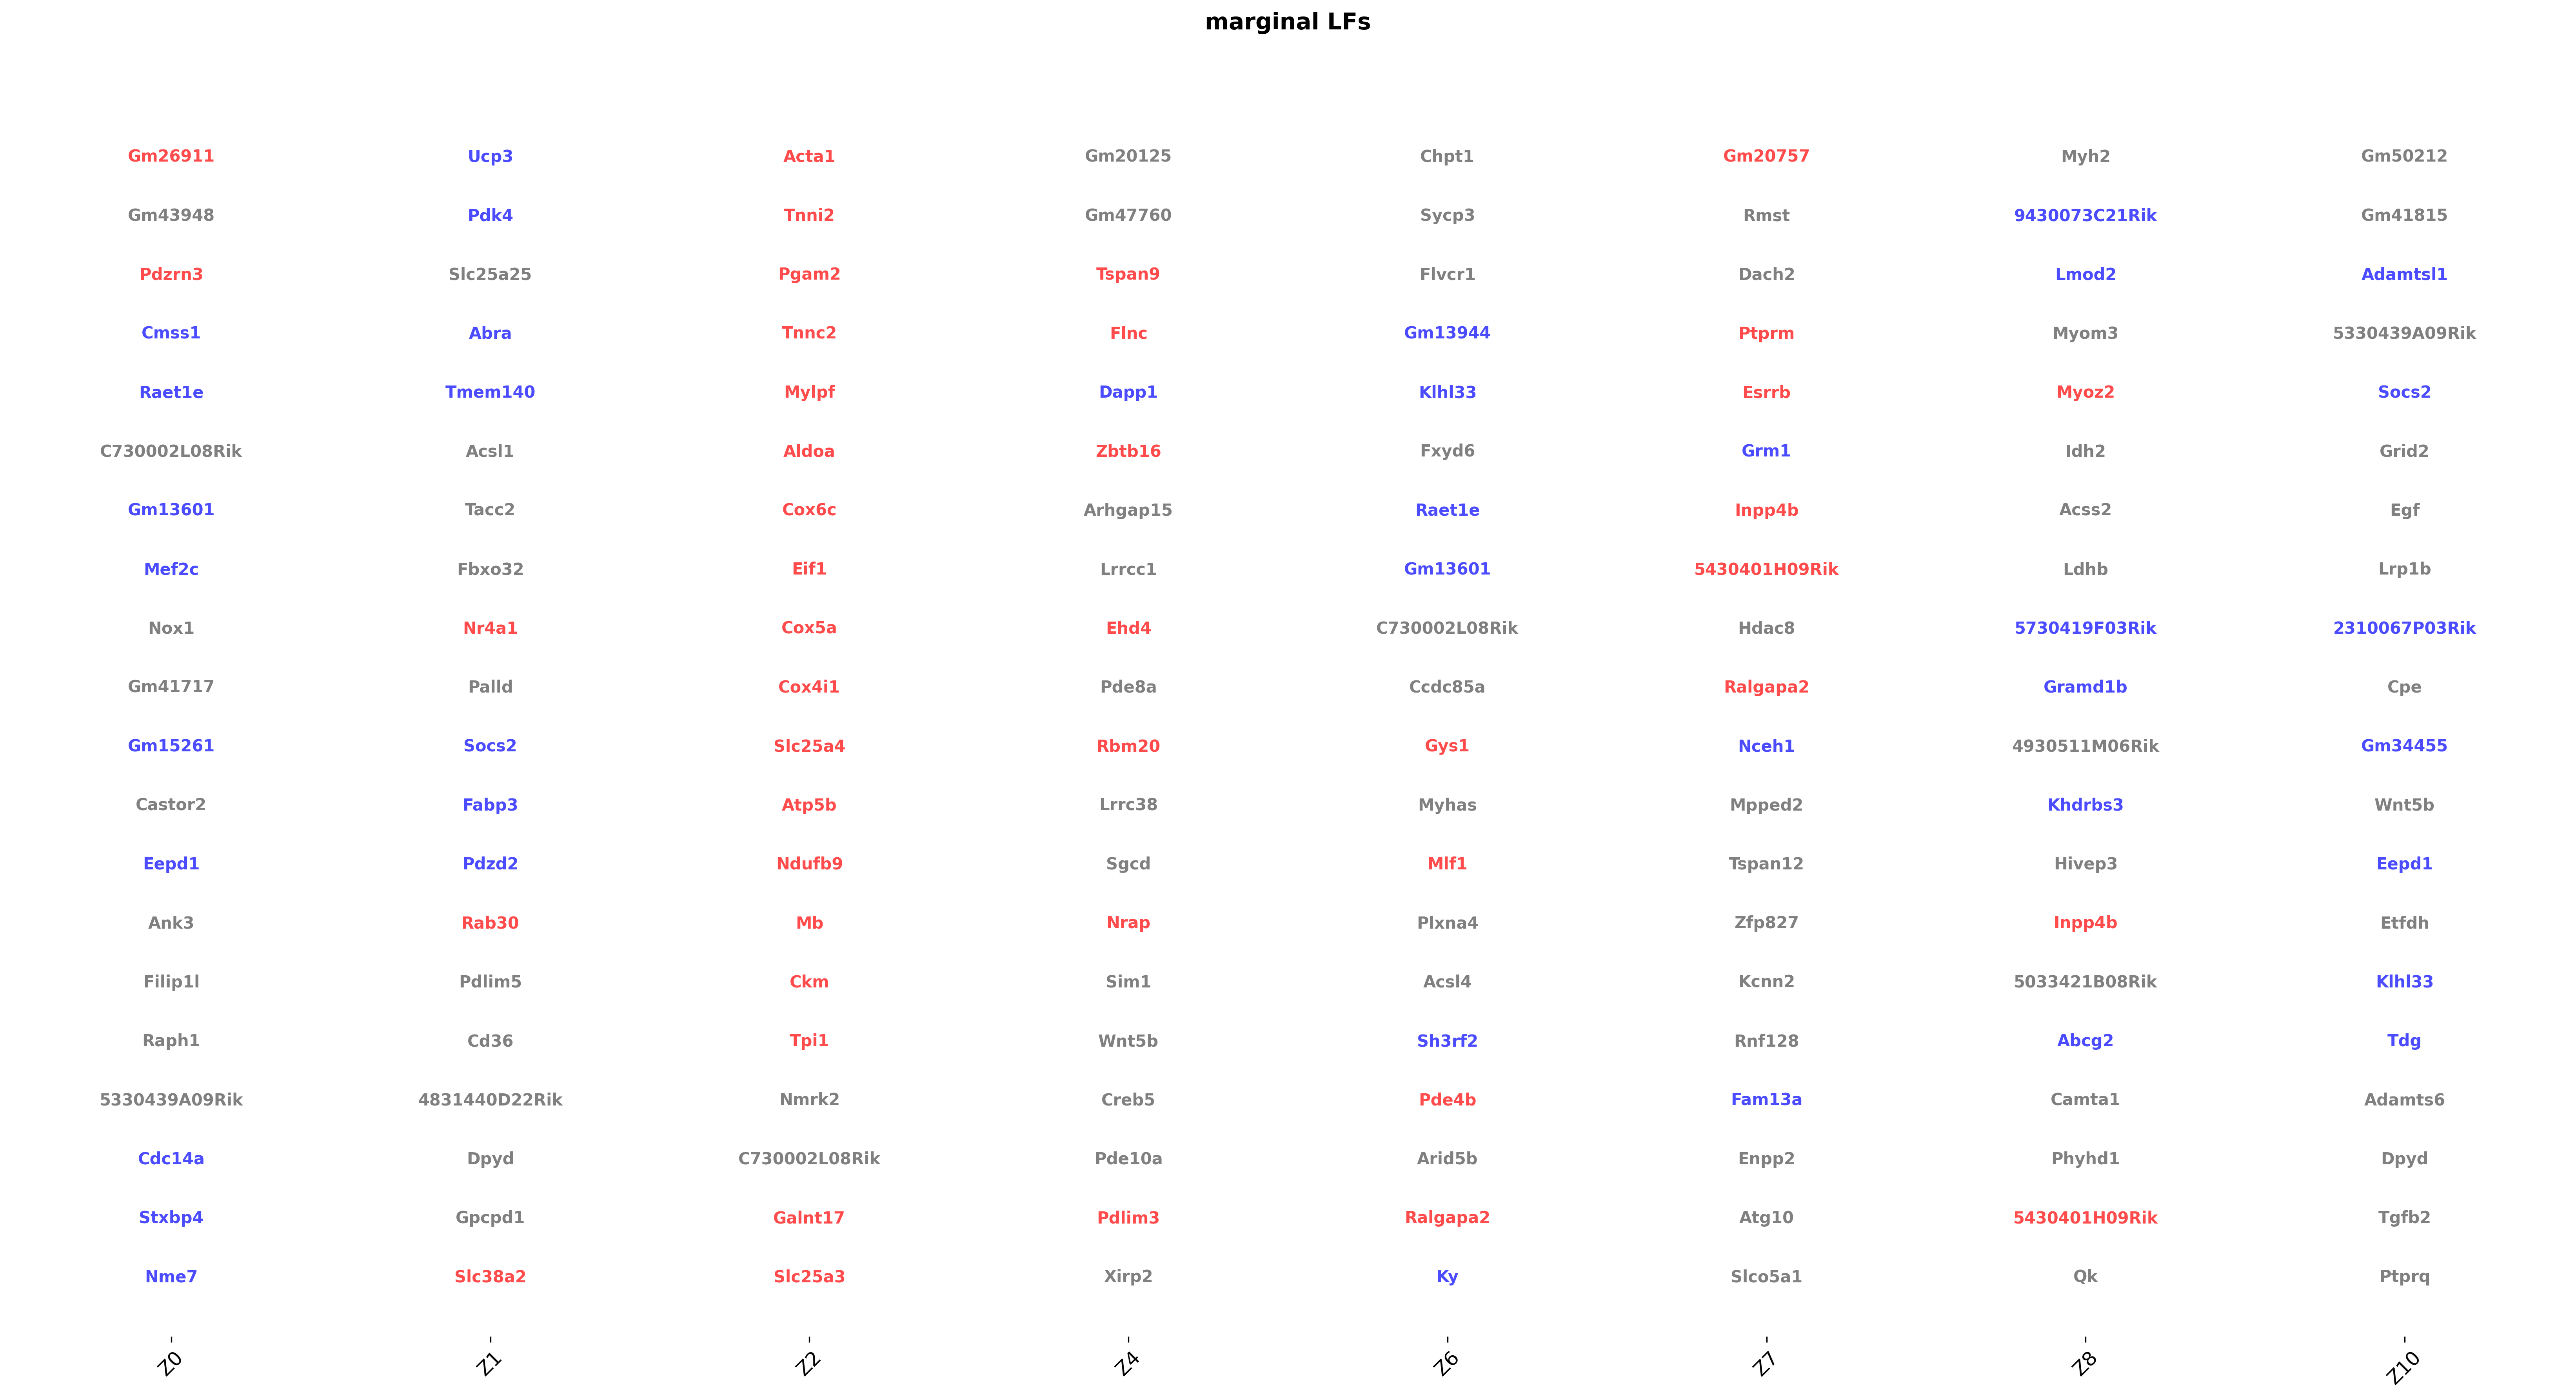

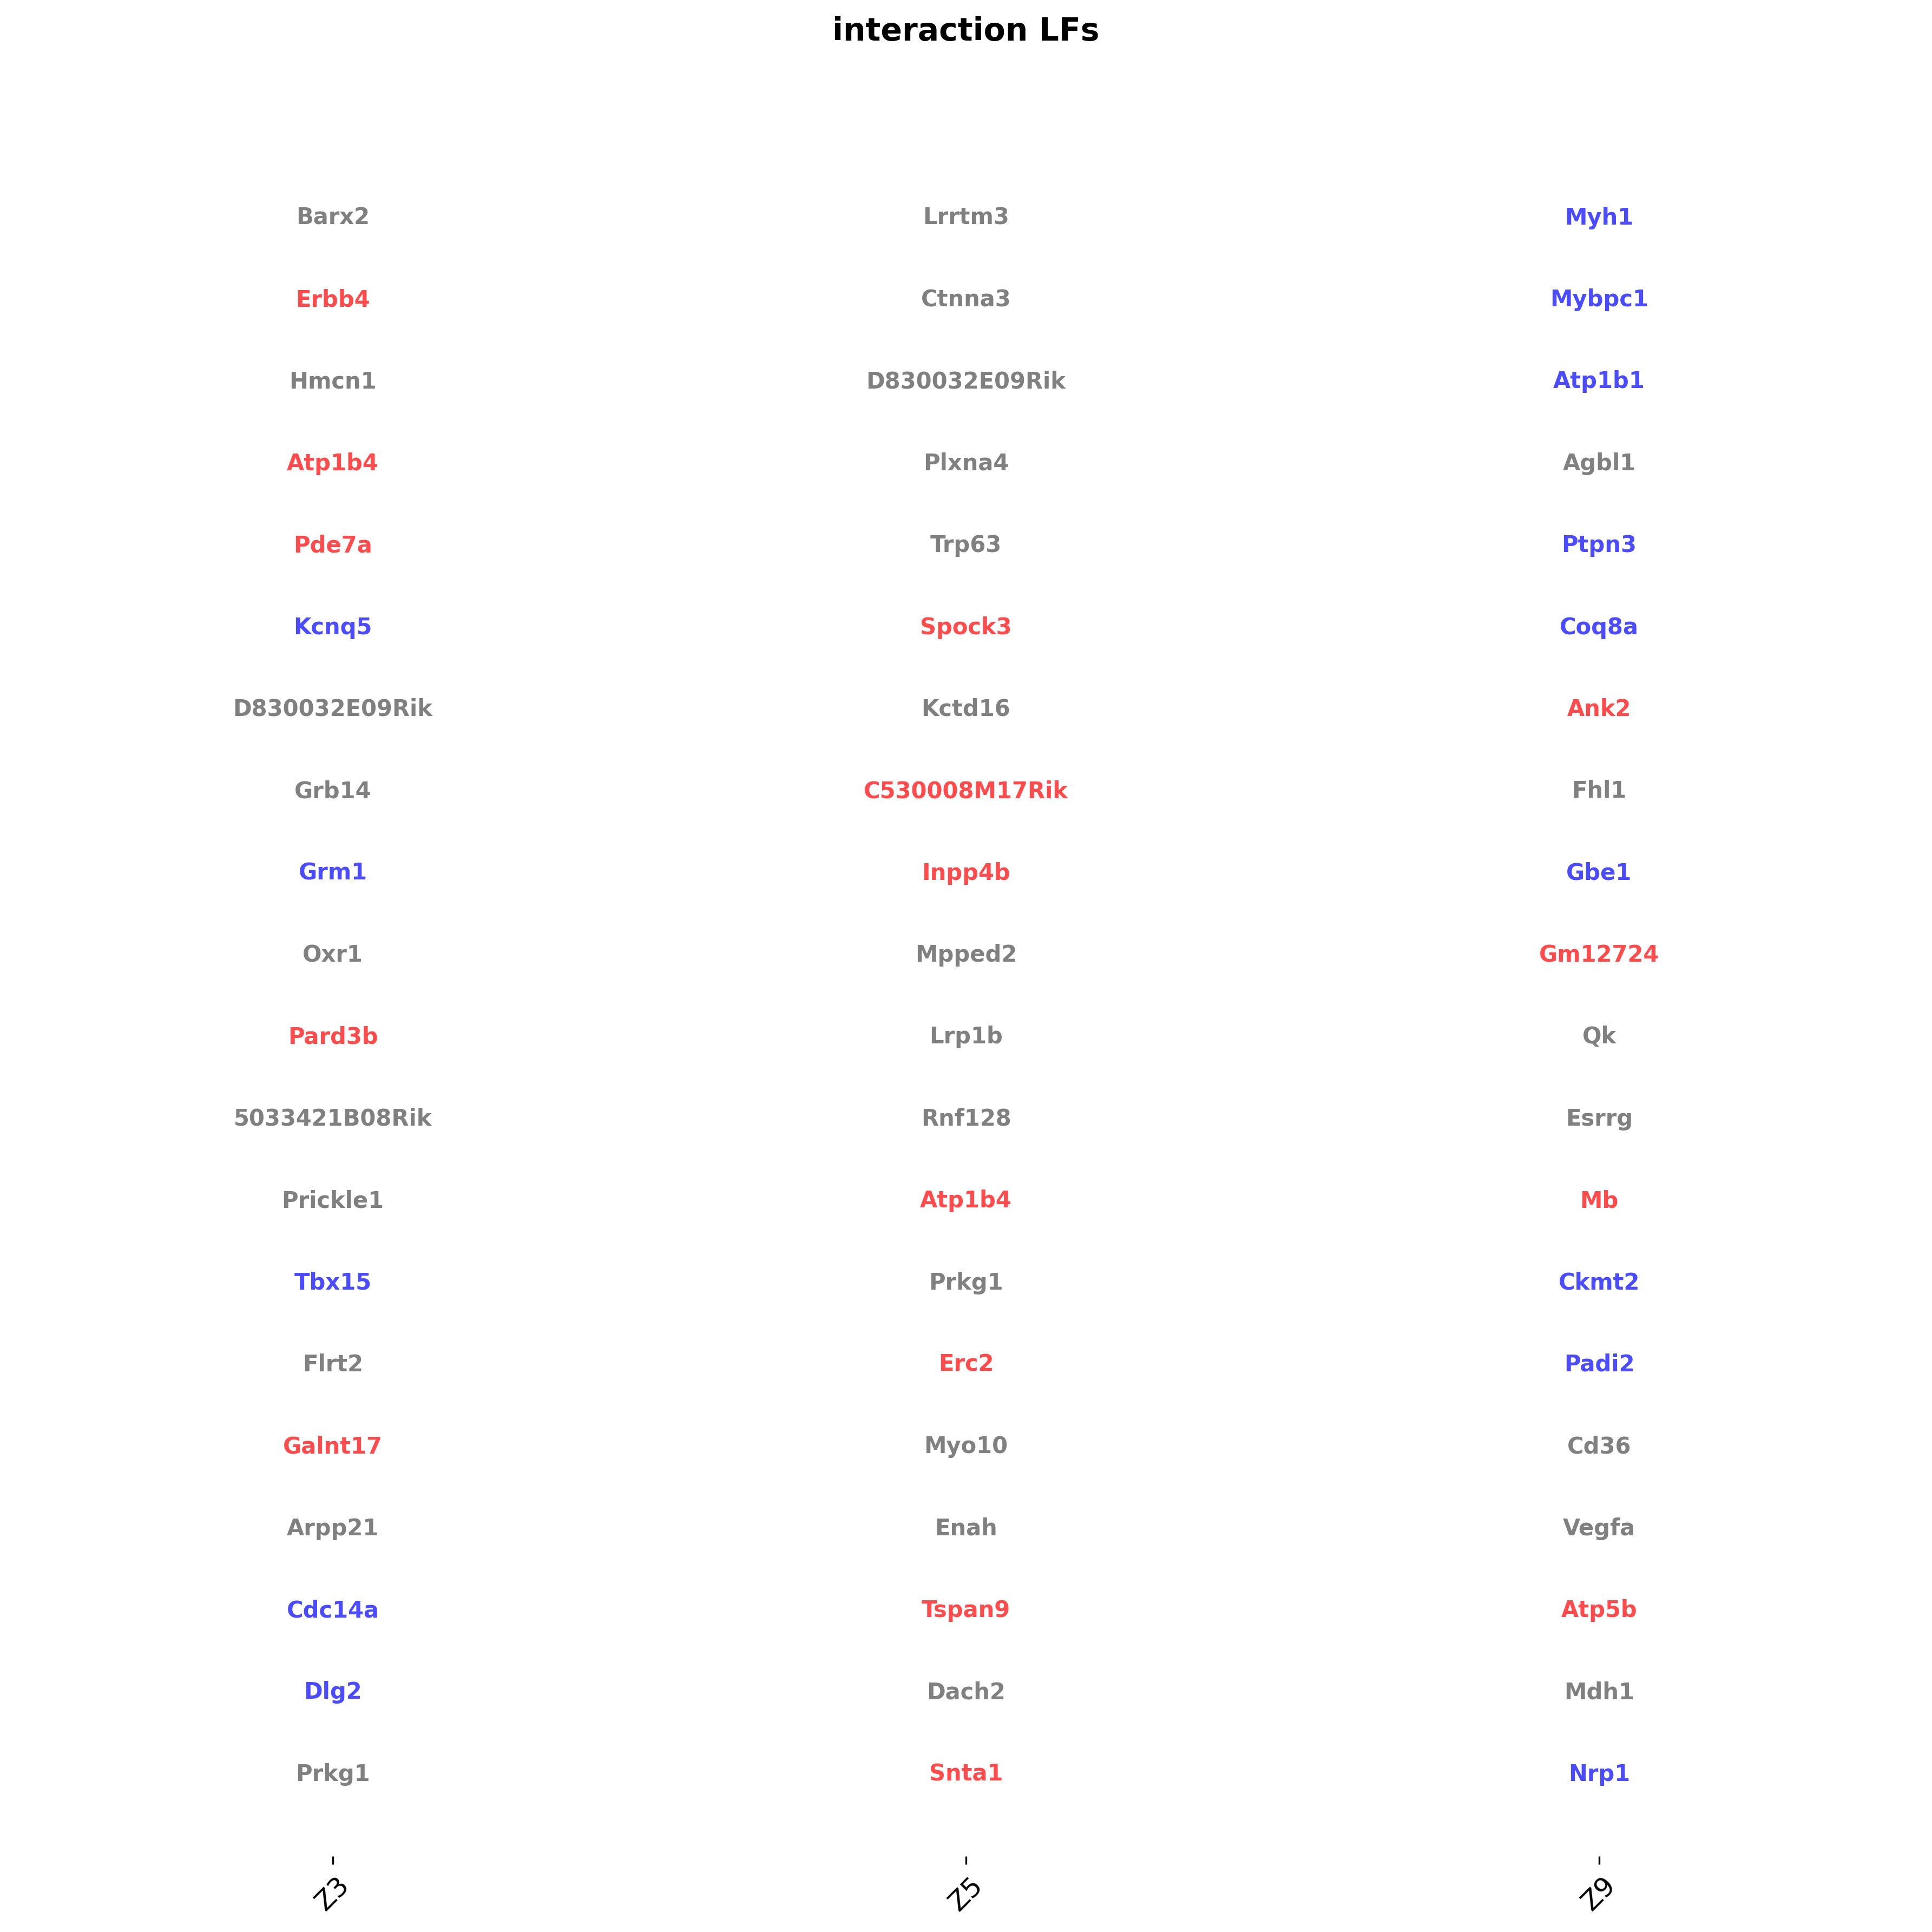

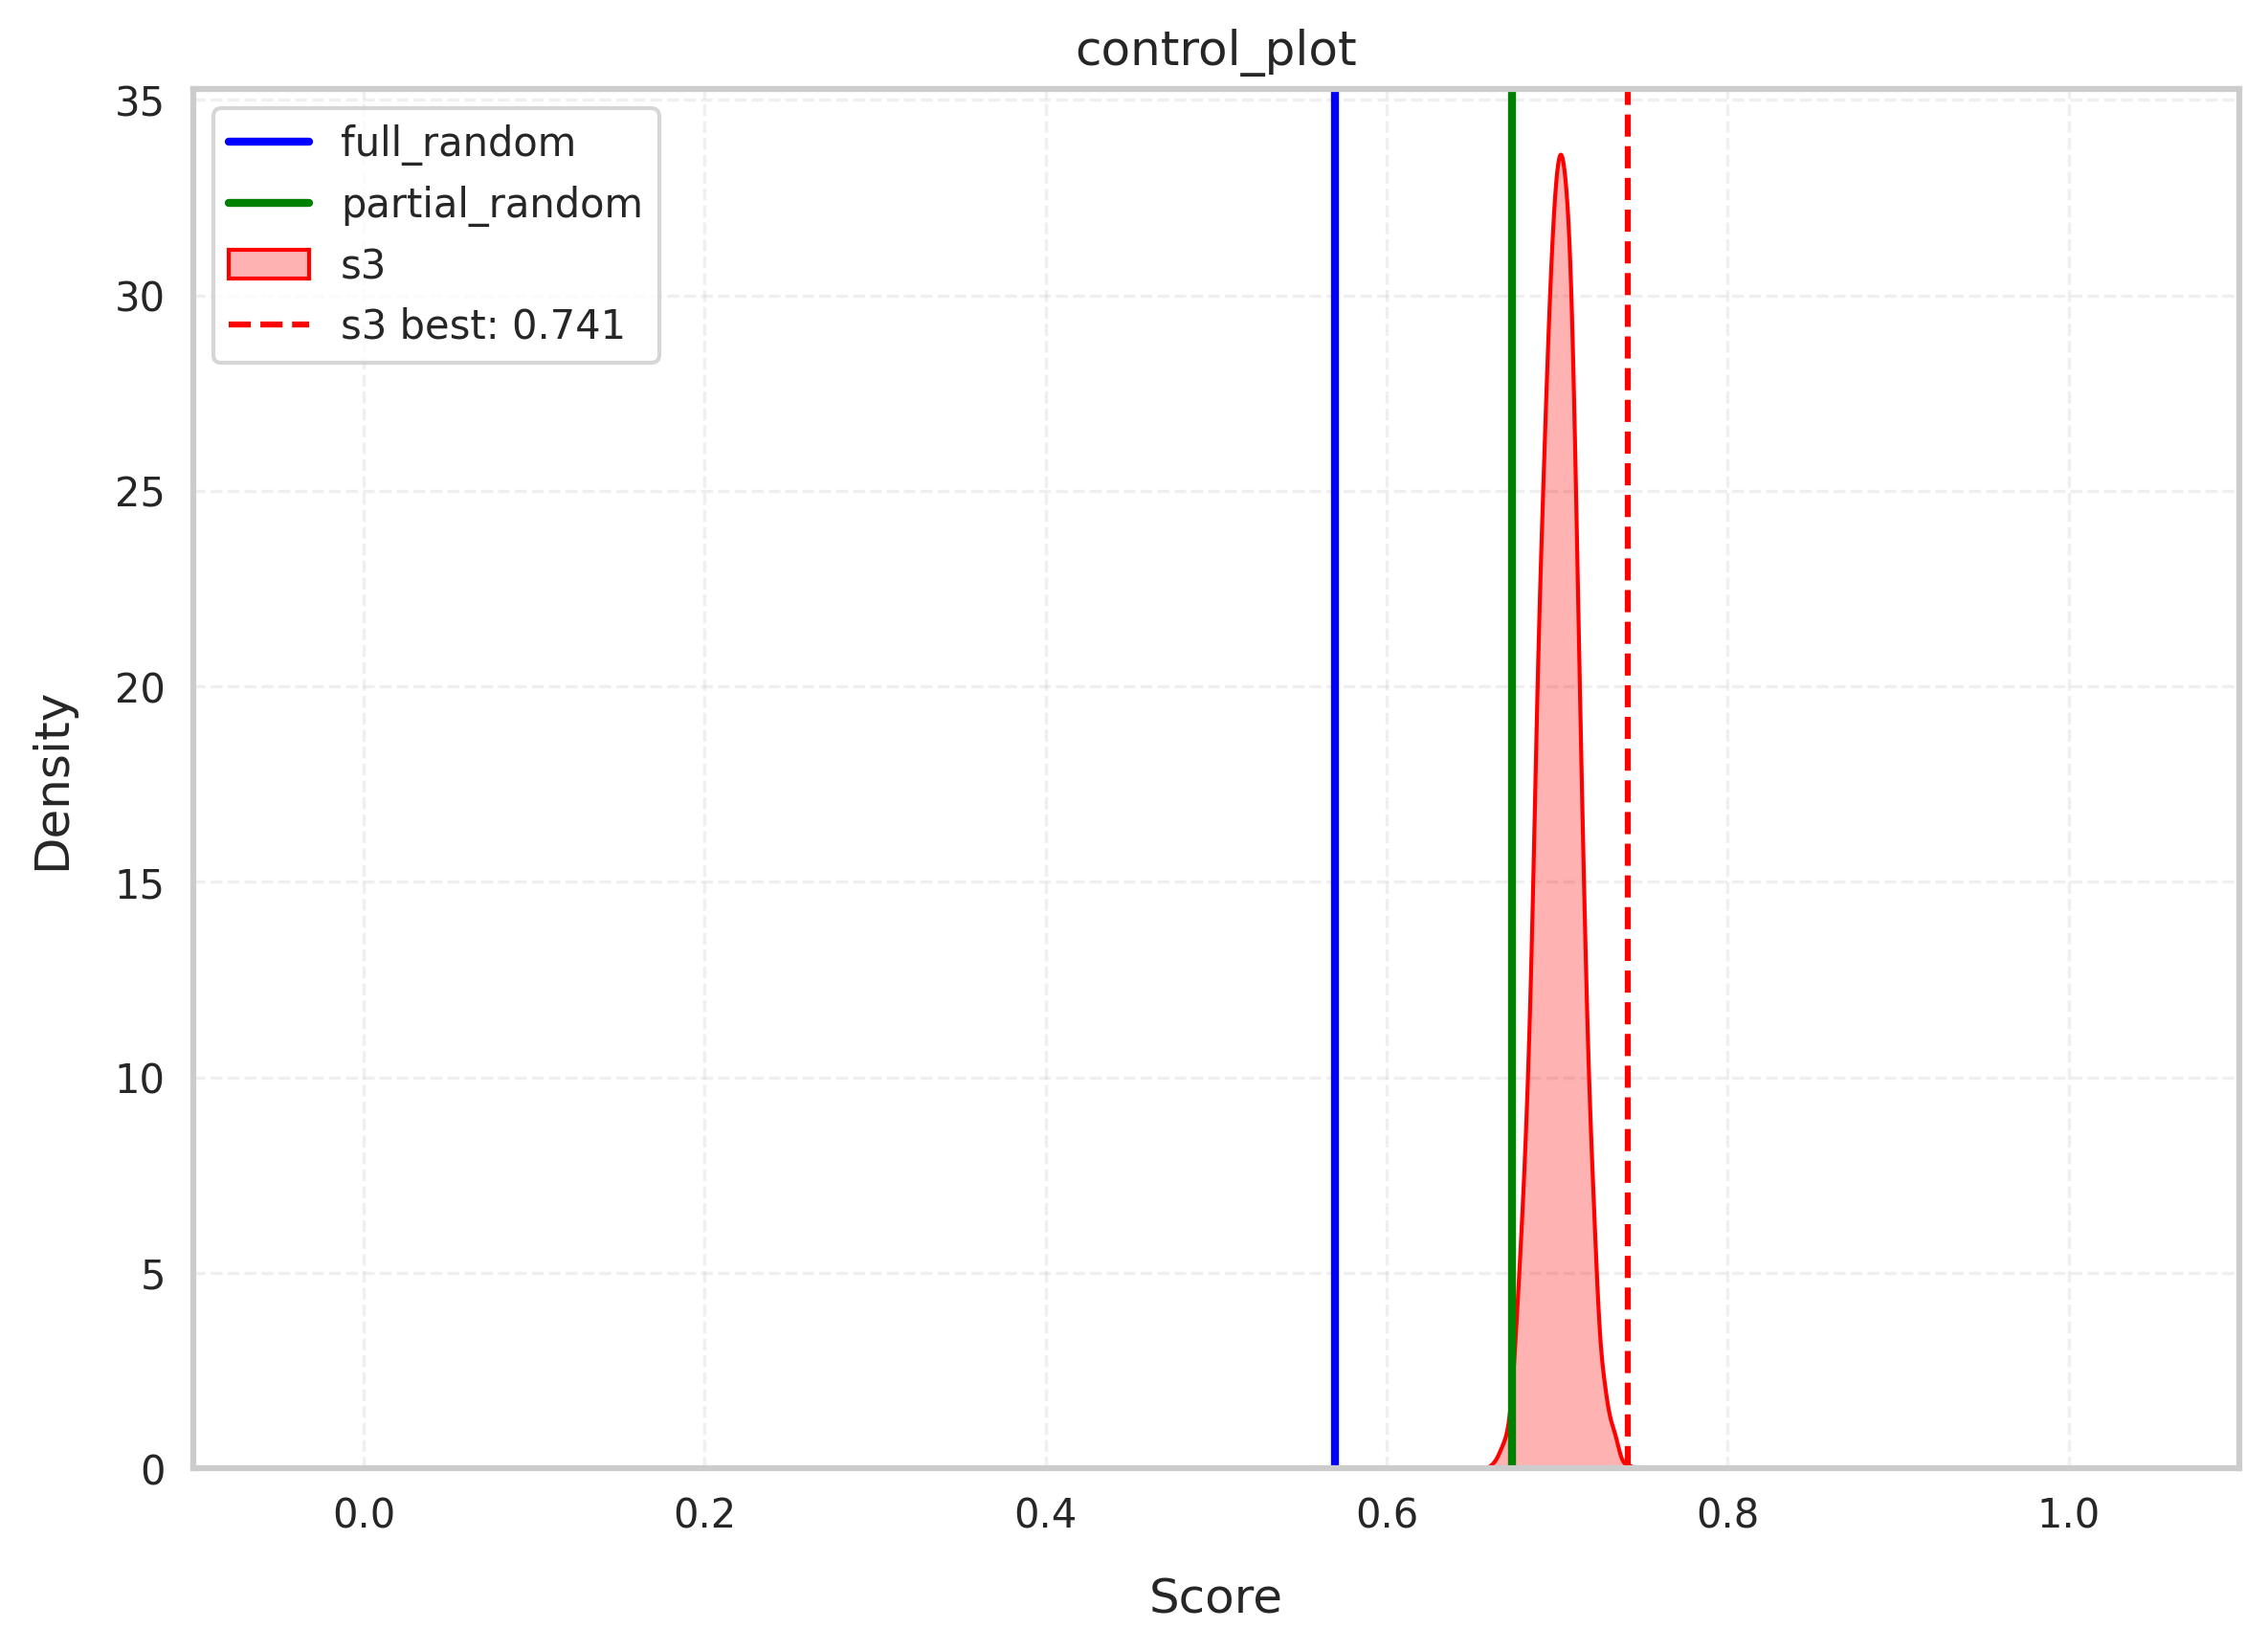

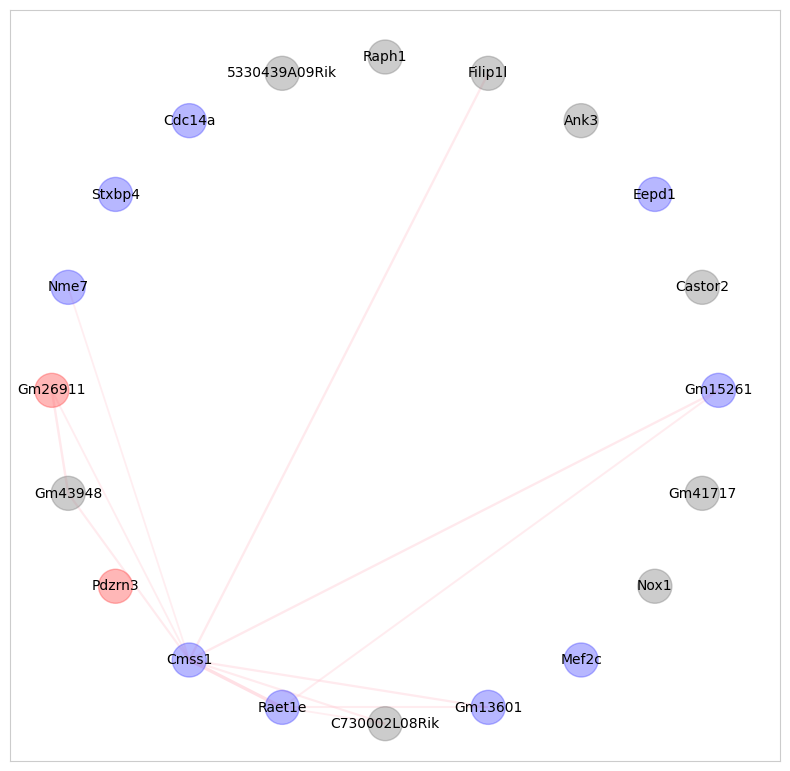

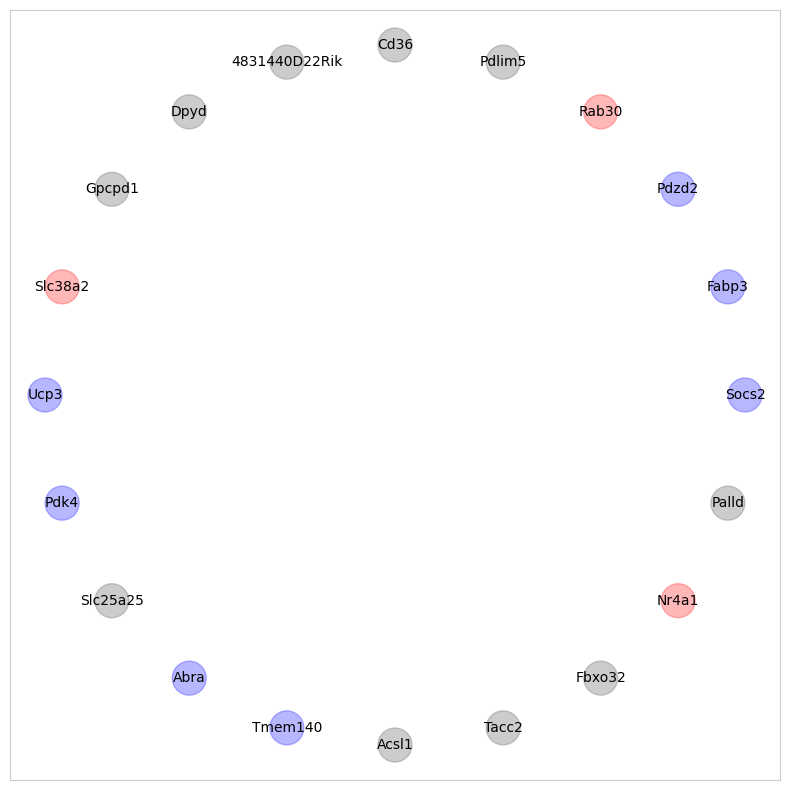

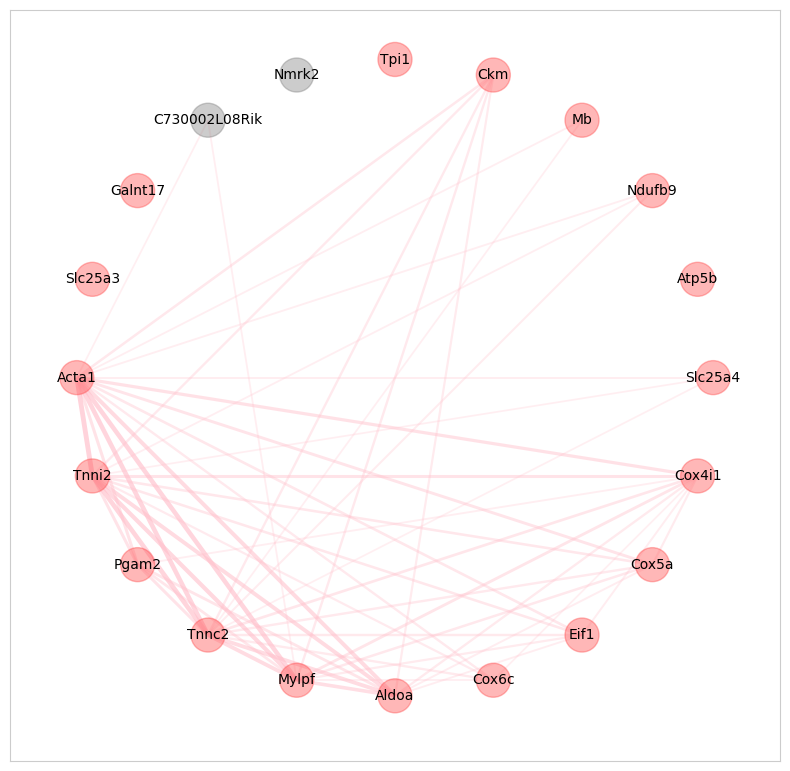

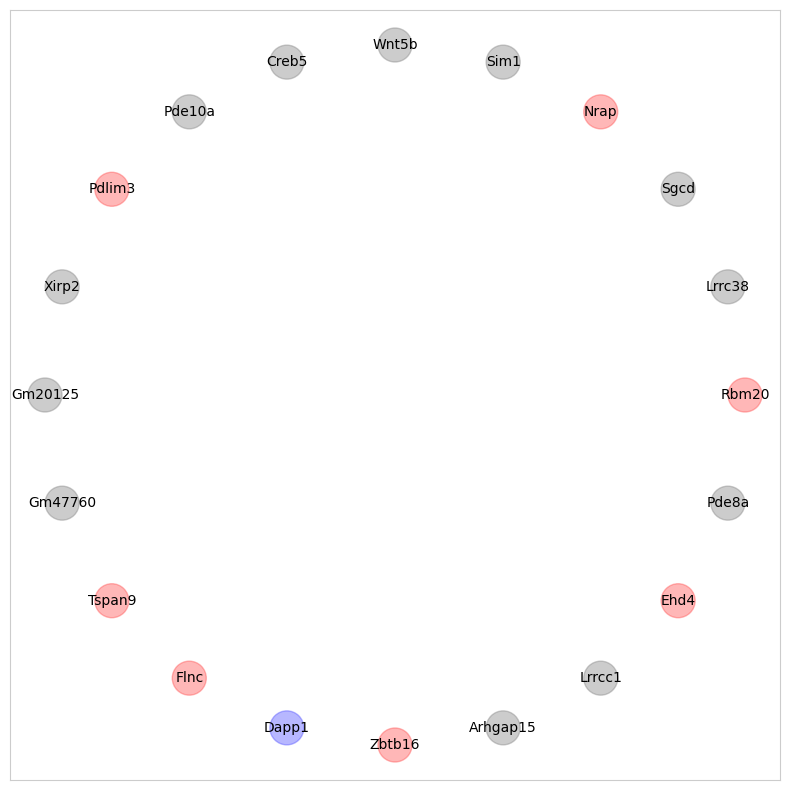

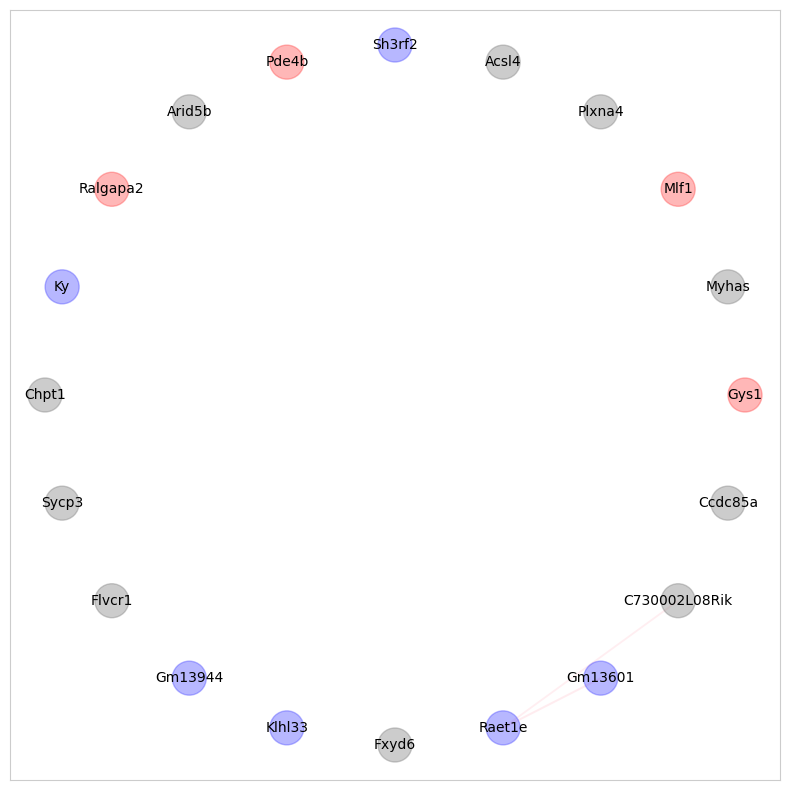

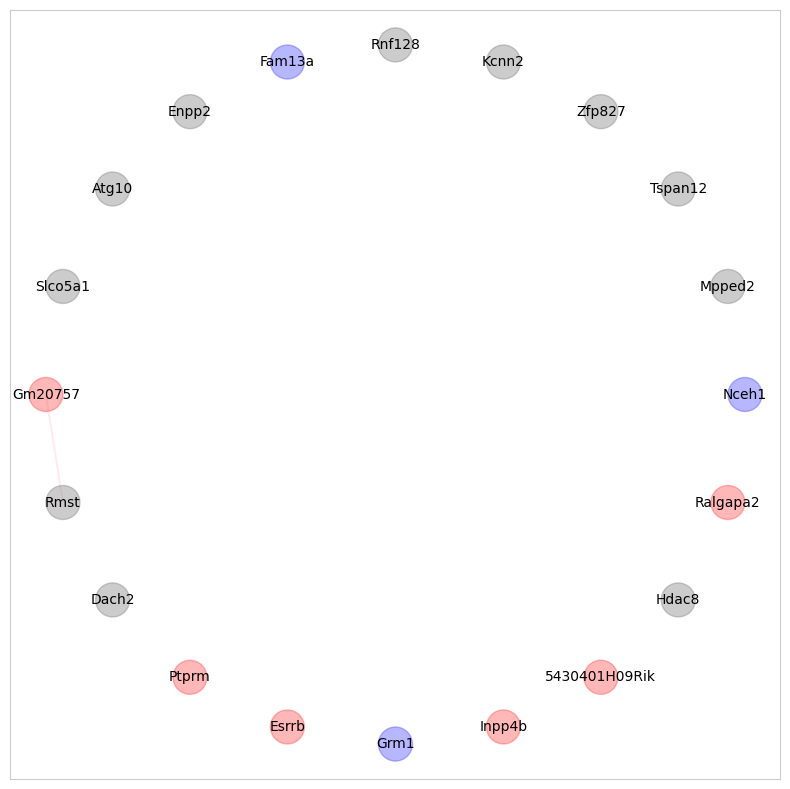

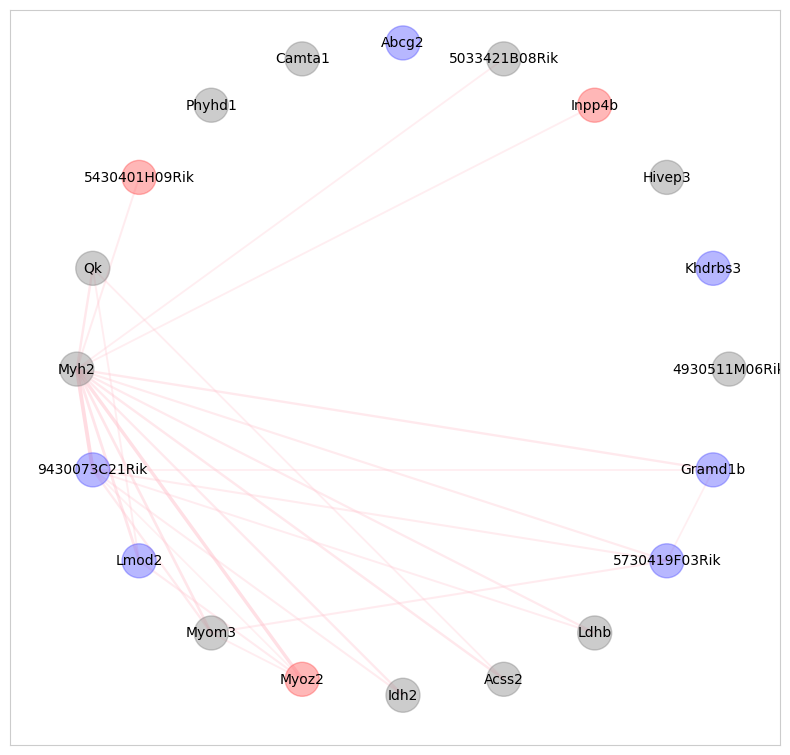

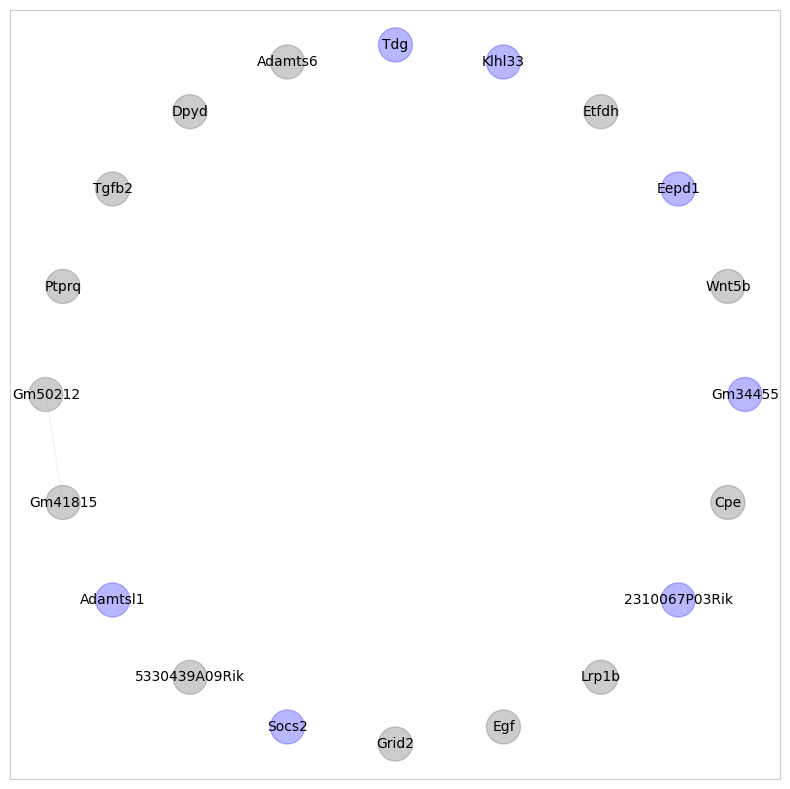

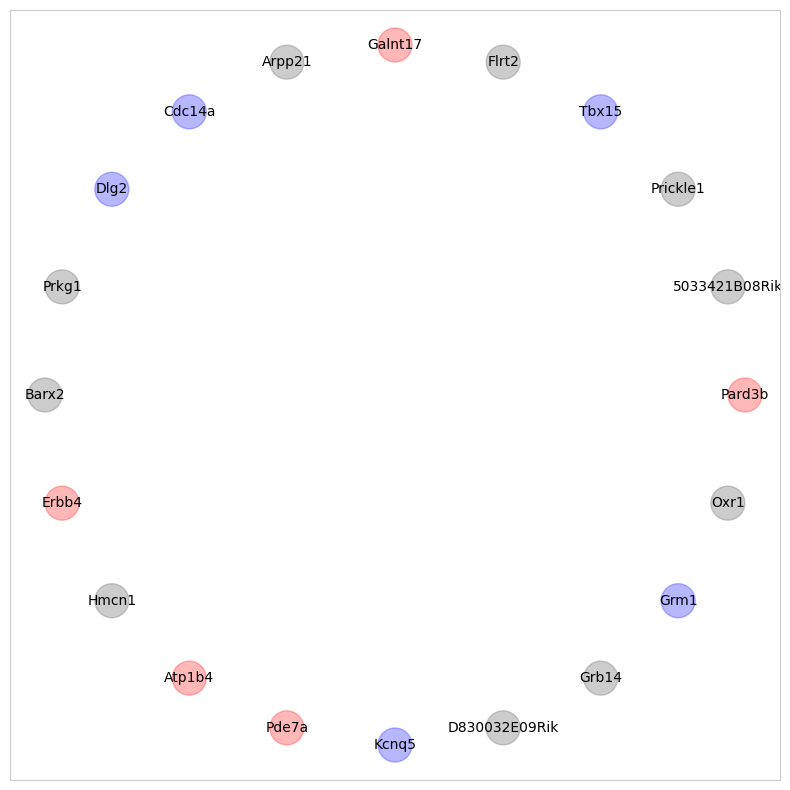

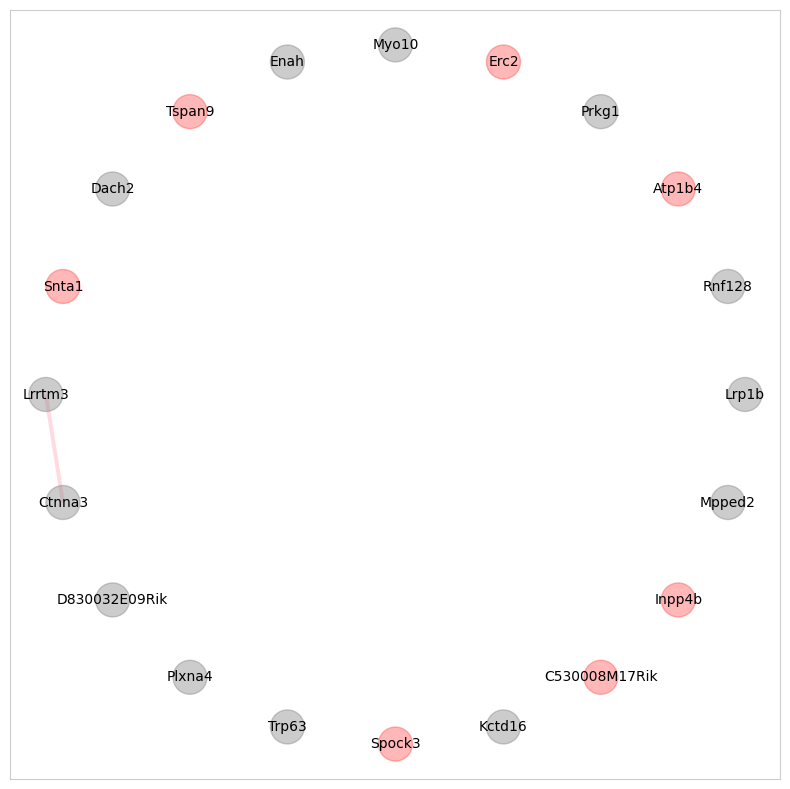

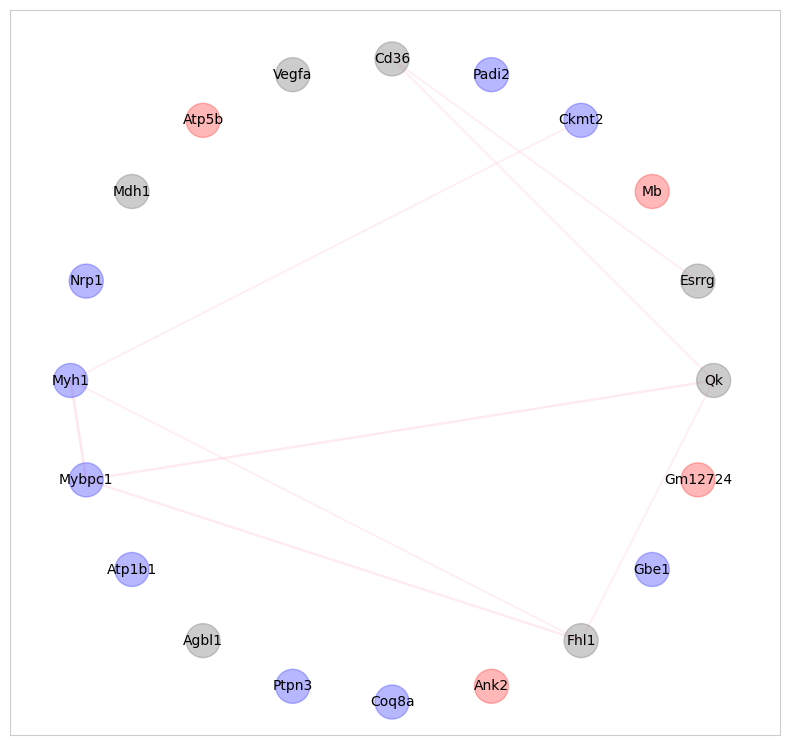

In [3]:
slider = OptimizeSLIDE(input_params)
slider.run_pipeline(verbose=True, n_workers=1)